In [1]:
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
#from scipy.stats import ttest_ind
import math
import json 
import ast


### Loading DATA

In [2]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])


# TMDB dataset
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title', how = 'inner') #isn't it better to do with wikipedia id? 

In [3]:
# cleaning some movies columns 
def cleaning_fct(pattern):
    if pd.isna(pattern) or pattern == '{}':
        return None
    else:
        dict = json.loads(pattern)
        pattern = list(dict.values())
        return pattern

df_movies_tmdb['spoken_languages_x'] = df_movies_tmdb['spoken_languages_x'].apply(cleaning_fct)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning_fct)
df_movies_tmdb['genres_x'] = df_movies_tmdb['genres_x'].apply(cleaning_fct)

df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning_fct)
df_movies['countries'] = df_movies['countries'].apply(cleaning_fct)
df_movies['genres'] = df_movies['genres'].apply(cleaning_fct)

In [4]:
# from the merged dataset, drop columns with more missing data and renaming the remaining columns
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={"spoken_languages_x": "spoken_languages"}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={"genres_x": "genres"}) 
df_movies_tmdb = df_movies_tmdb.drop(['release_date_x'], axis = 1).rename(columns={"release_date_y": "release_date"}) 

In [5]:
# clean missing values in release_date and clean dates to keep the release year only
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date'])
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].str[:4].astype(int)

df_movies = df_movies.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].str[:4].astype(int)

#print(df_characters['actor_ethnicity'].sample(20))
df_movies = df_movies[df_movies['release_date'] != '1010']

### Characters DataFrame

In [6]:
# Count the number of NaN values in 'actor_ethnicity'
na_count = df_characters['actor_ethnicity'].isna().sum()
print(f"Number of NaN values in 'actor_ethnicity': {na_count}")

# Count the number of unique values in 'actor_ethnicity', excluding NaN
unique_ethnicities_count = df_characters['actor_ethnicity'].nunique(dropna=True)
print(f"Number of unique ethnicities in 'actor_ethnicity': {unique_ethnicities_count}")

# Total number of entries in 'actor_ethnicity' column
total_entries = len(df_characters['actor_ethnicity'])
print(f"Total entries in 'actor_ethnicity': {total_entries}")

# Calculate proportions
na_proportion = na_count / total_entries
non_na_proportion = (total_entries - na_count) / total_entries
print(f"Proportion of NaN values in 'actor_ethnicity': {na_proportion:.2%}")
print(f"Proportion of non-NaN values in 'actor_ethnicity': {non_na_proportion:.2%}")

# Count the number of unique actors who have a non-NaN ethnicity
actors_with_ethnicity = df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()
print(f"Number of unique actors who have an ethnicity: {actors_with_ethnicity}")

# Count the number of unique actors in total
total_unique_actors = df_characters['actor_name'].nunique()
print(f"Total number of unique actors: {total_unique_actors}")

# Count the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
unique_movies = df_characters['freebase_id'].nunique()
print(f"Total number of unique movies: {unique_movies}")

# Count the number of unique movies with at least one actor who has a specified ethnicity
movies_with_ethnicity = df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique()  
print(f"Number of unique movies with at least one actor having an ethnicity: {movies_with_ethnicity}")

Number of NaN values in 'actor_ethnicity': 344611
Number of unique ethnicities in 'actor_ethnicity': 479
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of non-NaN values in 'actor_ethnicity': 23.53%
Number of unique actors who have an ethnicity: 8148
Total number of unique actors: 134078
Total number of unique movies: 64330
Number of unique movies with at least one actor having an ethnicity: 37958


The actors' ethnicities are in the format of Freebase IDs. In order to translate them, I saved these unique IDs in a `.txt` file, which I translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}


In [7]:
#not needed anymore had to be done once 
#Collecting unique ethnicty freebase IDs into batches as query have limited processing limit
"""
unique_ethnicities = df_characters['actor_ethnicity'].dropna().unique().tolist()
batch_size = 50

#write them into .text file
with open("unique_actor_ethnicities_batches.txt", "w") as file:
    for i in range(0, len(unique_ethnicities), batch_size):
        batch = unique_ethnicities[i:i+batch_size]
        formatted_batch = " ".join(f'"{id}"' for id in batch)
        
        # Write the formatted batch to the file with a separator
        file.write(f"Batch {i//batch_size + 1}:\n")
        file.write(formatted_batch + "\n\n" + "-"*50 + "\n\n")
    
print("Batches of unique, cleaned Freebase IDs saved to 'unique_actor_ethnicities_batches.txt'")  """


'\nunique_ethnicities = df_characters[\'actor_ethnicity\'].dropna().unique().tolist()\nbatch_size = 50\n\n#write them into .text file\nwith open("unique_actor_ethnicities_batches.txt", "w") as file:\n    for i in range(0, len(unique_ethnicities), batch_size):\n        batch = unique_ethnicities[i:i+batch_size]\n        formatted_batch = " ".join(f\'"{id}"\' for id in batch)\n        \n        # Write the formatted batch to the file with a separator\n        file.write(f"Batch {i//batch_size + 1}:\n")\n        file.write(formatted_batch + "\n\n" + "-"*50 + "\n\n")\n    \nprint("Batches of unique, cleaned Freebase IDs saved to \'unique_actor_ethnicities_batches.txt\'")  '

In [8]:
#Translated everything on query.wikidata.org and printed them on .csv files 
query = './src/data/query/'
csv_files = [query + file for file in os.listdir(query) if file.endswith('.csv')]
label_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
label_df.columns = ["freebase_id","wikipedia_id" ,"label"]  
freebase_to_label = dict(zip(label_df["freebase_id"], label_df["label"]))

#Creating ethnicity label column where we map the freebse ethnicity Id to the label
df_characters["ethnicity_label"] = df_characters["actor_ethnicity"].map(freebase_to_label)
print(df_characters[["actor_ethnicity", "ethnicity_label"]].head()) 


  actor_ethnicity    ethnicity_label
0             NaN                NaN
1      /m/044038p                NaN
2         /m/0x67  African Americans
3             NaN                NaN
4             NaN                NaN


In [9]:
actor_ethnicity_nans = df_characters["actor_ethnicity"].isna().sum()
actor_ethnicity_non_nans = df_characters["actor_ethnicity"].notna().sum()
ethnicity_label_nans = df_characters["ethnicity_label"].isna().sum()
ethnicity_label_non_nans = df_characters["ethnicity_label"].notna().sum()

# Calculate percentage of missing data
actor_ethnicity_nan_percentage = (actor_ethnicity_nans / len(df_characters)) * 100
ethnicity_label_nan_percentage = (ethnicity_label_nans / len(df_characters)) * 100

# Print results
print("Number of NaNs in 'actor_ethnicity':", actor_ethnicity_nans)
print("Number of non-NaNs in 'actor_ethnicity':", actor_ethnicity_non_nans)
print("Percentage of missing data in 'actor_ethnicity':", actor_ethnicity_nan_percentage, "%")
print("Number of NaNs in 'ethnicity_label':", ethnicity_label_nans)
print("Number of non-NaNs in 'ethnicity_label':", ethnicity_label_non_nans)
print("Percentage of missing data in 'ethnicity_label':", ethnicity_label_nan_percentage, "%")

Number of NaNs in 'actor_ethnicity': 344611
Number of non-NaNs in 'actor_ethnicity': 106058
Percentage of missing data in 'actor_ethnicity': 76.46654196317031 %
Number of NaNs in 'ethnicity_label': 347766
Number of non-NaNs in 'ethnicity_label': 102903
Percentage of missing data in 'ethnicity_label': 77.16661230304281 %


In [10]:
# Get the counts of unique values in 'ethnicity_label', including NaN
ethnicity_counts = df_characters['ethnicity_label'].value_counts(dropna=False)

# Display all unique values in 'ethnicity_label' without truncation
pd.set_option('display.max_rows', None)  # Display all rows without truncation
print("Unique values in 'ethnicity_label' and their counts:")
print(ethnicity_counts)
pd.reset_option('display.max_rows')  


Unique values in 'ethnicity_label' and their counts:
ethnicity_label
NaN                                       347766
Indians                                    16351
African Americans                          10159
Jewish people                              10121
English people                              6165
Irish Americans                             3857
Italian Americans                           2956
White people                                2307
White Americans                             2250
Scottish Americans                          2223
Irish people                                1637
British                                     1433
French                                      1350
Italians                                    1305
Tamil                                       1215
Punjabis                                    1155
Malayali                                    1146
Scottish people                             1028
Swedish Americans                            977


### Clustering Ethnicities: 
- In the clusters.txt file you'll find principally main clusters manually made for different regions. Double ethnicities will be assigned to both groups. 
    The clusters in the group are mainly: Europeans(East-West Europe)/Latin Americans/Africans(Subsaharians)/MENA(Middle East and North Africa)/North America/Carribean-Native Americans/Oceania/Asia and India
- Bigger divides were kept, so if we need a bit more "detailed" information on our data we can. But bigger, groups will essentialy remain: 

In [11]:
# Load the dictionary from the .txt file
with open(DATA +"ethnicities_clusters.txt", "r") as file:
    ethnicities = ast.literal_eval(file.read())

In [12]:
# Map each actor's ethnicity to ALL clusters it belongs to
ethnicity_to_clusters = {}
for cluster, labels in ethnicities.items():
    for label in labels:
        ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)

In [13]:
# Identify unique ethnicity labels where 'mapped_clusters' is empty
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].apply(lambda x: isinstance(x, list) and len(x) == 0)]['ethnicity_label'].unique()

print(unmatched_ethnicities)

[nan 'Jewish people' 'مسح' 'history of the Jews in India'
 'Bohemian People' 'multiracial people' 'peoples of the Caucasus']


In [14]:
actor_ethnicity_nans = df_characters["actor_ethnicity"].isna().sum()
actor_ethnicity_non_nans = df_characters["actor_ethnicity"].notna().sum()
ethnicity_label_nans = df_characters["ethnicity_label"].isna().sum()
ethnicity_label_non_nans = df_characters["ethnicity_label"].notna().sum()

# pourcentagee of missing data
actor_ethnicity_nan_percentage = (actor_ethnicity_nans / len(df_characters)) * 100
ethnicity_label_nan_percentage = (ethnicity_label_nans / len(df_characters)) * 100


movies_with_labeledethnicity = df_characters[df_characters['mapped_clusters'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['freebase_id'].nunique()


# Print results
print("Number of NaNs in 'actor_ethnicity':", actor_ethnicity_nans)
print("Number of non-NaNs in 'actor_ethnicity':", actor_ethnicity_non_nans)
print("Percentage of missing data in 'actor_ethnicity':", actor_ethnicity_nan_percentage, "%")
print("Number of NaNs in 'ethnicity_label':", ethnicity_label_nans)
print("Number of non-NaNs in 'ethnicity_label':", ethnicity_label_non_nans)
print("Percentage of missing data in 'ethnicity_label':", ethnicity_label_nan_percentage, "%")
print(f"Number of unique movies with at least one actor having an ethnicity: {movies_with_ethnicity}")
print(f"Number of unique movies with at least one actor having a labeled ethnicity: {movies_with_ethnicity}")
print(f"Number of unique movies with at least one actor having a classified ethnicity: {movies_with_labeledethnicity}")

Number of NaNs in 'actor_ethnicity': 344611
Number of non-NaNs in 'actor_ethnicity': 106058
Percentage of missing data in 'actor_ethnicity': 76.46654196317031 %
Number of NaNs in 'ethnicity_label': 347766
Number of non-NaNs in 'ethnicity_label': 102903
Percentage of missing data in 'ethnicity_label': 77.16661230304281 %
Number of unique movies with at least one actor having an ethnicity: 37958
Number of unique movies with at least one actor having a labeled ethnicity: 37958
Number of unique movies with at least one actor having a classified ethnicity: 35000


- Some of the ethnicities being hard to map, the information not being complete. We complemented our dataset whith some information formw wikidata. Where for each actor (using his freebase_id), we request a query and retrieve ethnicity infos or nationality if available. The retrieved information are to be found in wikidata.csv now.  ( more details are below, need to =ake them into separate files)

In [15]:
df_wikidata = pd.read_csv('wikidata_actor_info.csv', sep=',', header=None, names=['freebaseID', 'actorLabel' , 'ethnicityLabel' , 'nationalityLabel'])

In [16]:
#unmatched/ambiguous ethnicities
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].apply(lambda x: isinstance(x, list) and len(x) == 0)]['ethnicity_label'].unique()
#merging wikidata with df_characters
df_merged = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, return it as NaN (skip filling)
        return row['ethnicity_label']  # Keeps it as is ( NaN)
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )


df_merged['ethnicity_label'] = df_merged.apply(fill_ethnicity, axis=1)
df_merged.head(20) 

,wikipedia_id,freebase_id,release,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,age_at_release,freebase_map,freebase_character_id,freebase_actor_id,ethnicity_label,mapped_clusters,freebaseID,actorLabel,ethnicityLabel,nationalityLabel
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,United States of America,[],/m/03wcfv7,Wanda De Jesus,NaN,United States of America
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Canada,[],/m/0346l4,Natasha Henstridge,NaN,Canada
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,"[North Americans, North Americans, African]",NaN,NaN,NaN,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,United Kingdom,[],/m/034hyc,Jason Statham,NaN,United Kingdom
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,United States of America,[],/m/01y9xg,Clea DuVall,NaN,United States of America
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans,"[North Americans, North Americans, African]",NaN,NaN,NaN,NaN
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,United States of America,[],/m/06lj1m,Joanna Cassidy,NaN,United States of America
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,NaN,[],NaN,NaN,NaN,NaN
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,United States of America,[],/m/0ks8b0,Liam Waite,NaN,United States of America
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,United States of America,[],/m/03nrwdy,Duane Davis,NaN,United States of America


In [17]:
actor_ethnicity_nans = df_merged["actor_ethnicity"].isna().sum()
actor_ethnicity_non_nans = df_merged["actor_ethnicity"].notna().sum()
ethnicity_label_nans = df_merged["ethnicity_label"].isna().sum()
ethnicity_label_non_nans = df_merged["ethnicity_label"].notna().sum()

# pourcentagee of missing data
actor_ethnicity_nan_percentage = (actor_ethnicity_nans / len(df_merged)) * 100
ethnicity_label_nan_percentage = (ethnicity_label_nans / len(df_merged)) * 100

# Print results
print("Number of NaNs in 'actor_ethnicity':", actor_ethnicity_nans)
print("Number of non-NaNs in 'actor_ethnicity':", actor_ethnicity_non_nans)
print("Percentage of missing data in 'actor_ethnicity':", actor_ethnicity_nan_percentage, "%")
print("Number of NaNs in 'ethnicity_label':", ethnicity_label_nans)
print("Number of non-NaNs in 'ethnicity_label':", ethnicity_label_non_nans)
print("Percentage of missing data in 'ethnicity_label':", ethnicity_label_nan_percentage, "%")

Number of NaNs in 'actor_ethnicity': 372486
Number of non-NaNs in 'actor_ethnicity': 108161
Percentage of missing data in 'actor_ethnicity': 77.49679078408894 %
Number of NaNs in 'ethnicity_label': 175626
Number of non-NaNs in 'ethnicity_label': 305021
Percentage of missing data in 'ethnicity_label': 36.53949780192116 %


As we see the percentage of missing data droped by a HALF.

In [18]:
#mapping the new ethnicities to our clusters (the clusters.txt have been modified for this step)
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_merged['mapped_clusters'] = df_merged['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [77]:
#unmatched_ethnicities_df['ethnicity_label'].dropna().unique()


array(['Jewish people', 'مسح', 'Karay-a people', 'The Bahamas',
       'history of the Jews in India', 'Nazi Germany', 'Cisleithania',
       'Kingdom of Hawaiʻi', 'Bohemian People', 'Korean Empire',
       'Kingdom of Romania', 'multiracial people', 'Albania',
       'Beiyang Government', 'Samoa', 'Kosovo', 'Bengal',
       "Tuvan People's Republic", 'Q25589681', 'Gujarati Canadians',
       'peoples of the Caucasus'], dtype=object)

In [19]:
# Debugging: Print ethnicity labels that don't match any cluster
unmatched_ethnicities = df_merged[df_merged['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label'].unique()

print("Unmatched ethnicity labels:", unmatched_ethnicities)

Unmatched ethnicity labels: [nan 'Jewish people' 'مسح' 'Karay-a people' 'The Bahamas'
 'history of the Jews in India' 'Nazi Germany' 'Cisleithania'
 'Kingdom of Hawaiʻi' 'Bohemian People' 'Korean Empire'
 'Kingdom of Romania' 'multiracial people' 'Albania' 'Beiyang Government'
 'Samoa' 'Kosovo' 'Bengal' "Tuvan People's Republic" 'Q25589681'
 'Gujarati Canadians' 'peoples of the Caucasus']


In [20]:
# Drop these columns
df_merged = df_merged.drop(columns=['actorLabel', 'ethnicityLabel', 'nationalityLabel',  'freebaseID'])

In [21]:
df_merged.columns

Index(['wikipedia_id', 'freebase_id', 'release', 'character_name',
       'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity',
       'actor_name', 'age_at_release', 'freebase_map', 'freebase_character_id',
       'freebase_actor_id', 'ethnicity_label', 'mapped_clusters'],
      dtype='object')

## Primary Analysis

In [22]:
#merging based on wikipedia ID
df_g_characters = pd.merge(df_merged[['wikipedia_id', 'character_name', 'actor_ethnicity', 'ethnicity_label','mapped_clusters',  'actor_name']],
                             df_movies[['wikipedia_id','countries', 'title', 'release_date','genres']], 
                             on='wikipedia_id', how='inner')
df_g_characters.head()

,wikipedia_id,character_name,actor_ethnicity,ethnicity_label,mapped_clusters,actor_name,countries,title,release_date,genres
0,975900,Akooshay,NaN,United States of America,[North Americans],Wanda De Jesus,[United States of America],Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,..."
1,975900,Lieutenant Melanie Ballard,/m/044038p,Canada,[North Americans],Natasha Henstridge,[United States of America],Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,..."
2,975900,Desolation Williams,/m/0x67,African Americans,"[North Americans, African]",Ice Cube,[United States of America],Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,..."
3,975900,Sgt Jericho Butler,NaN,United Kingdom,[West European],Jason Statham,[United States of America],Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,..."
4,975900,Bashira Kincaid,NaN,United States of America,[North Americans],Clea DuVall,[United States of America],Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,..."


### Global tendencies and ethnicities per region: 

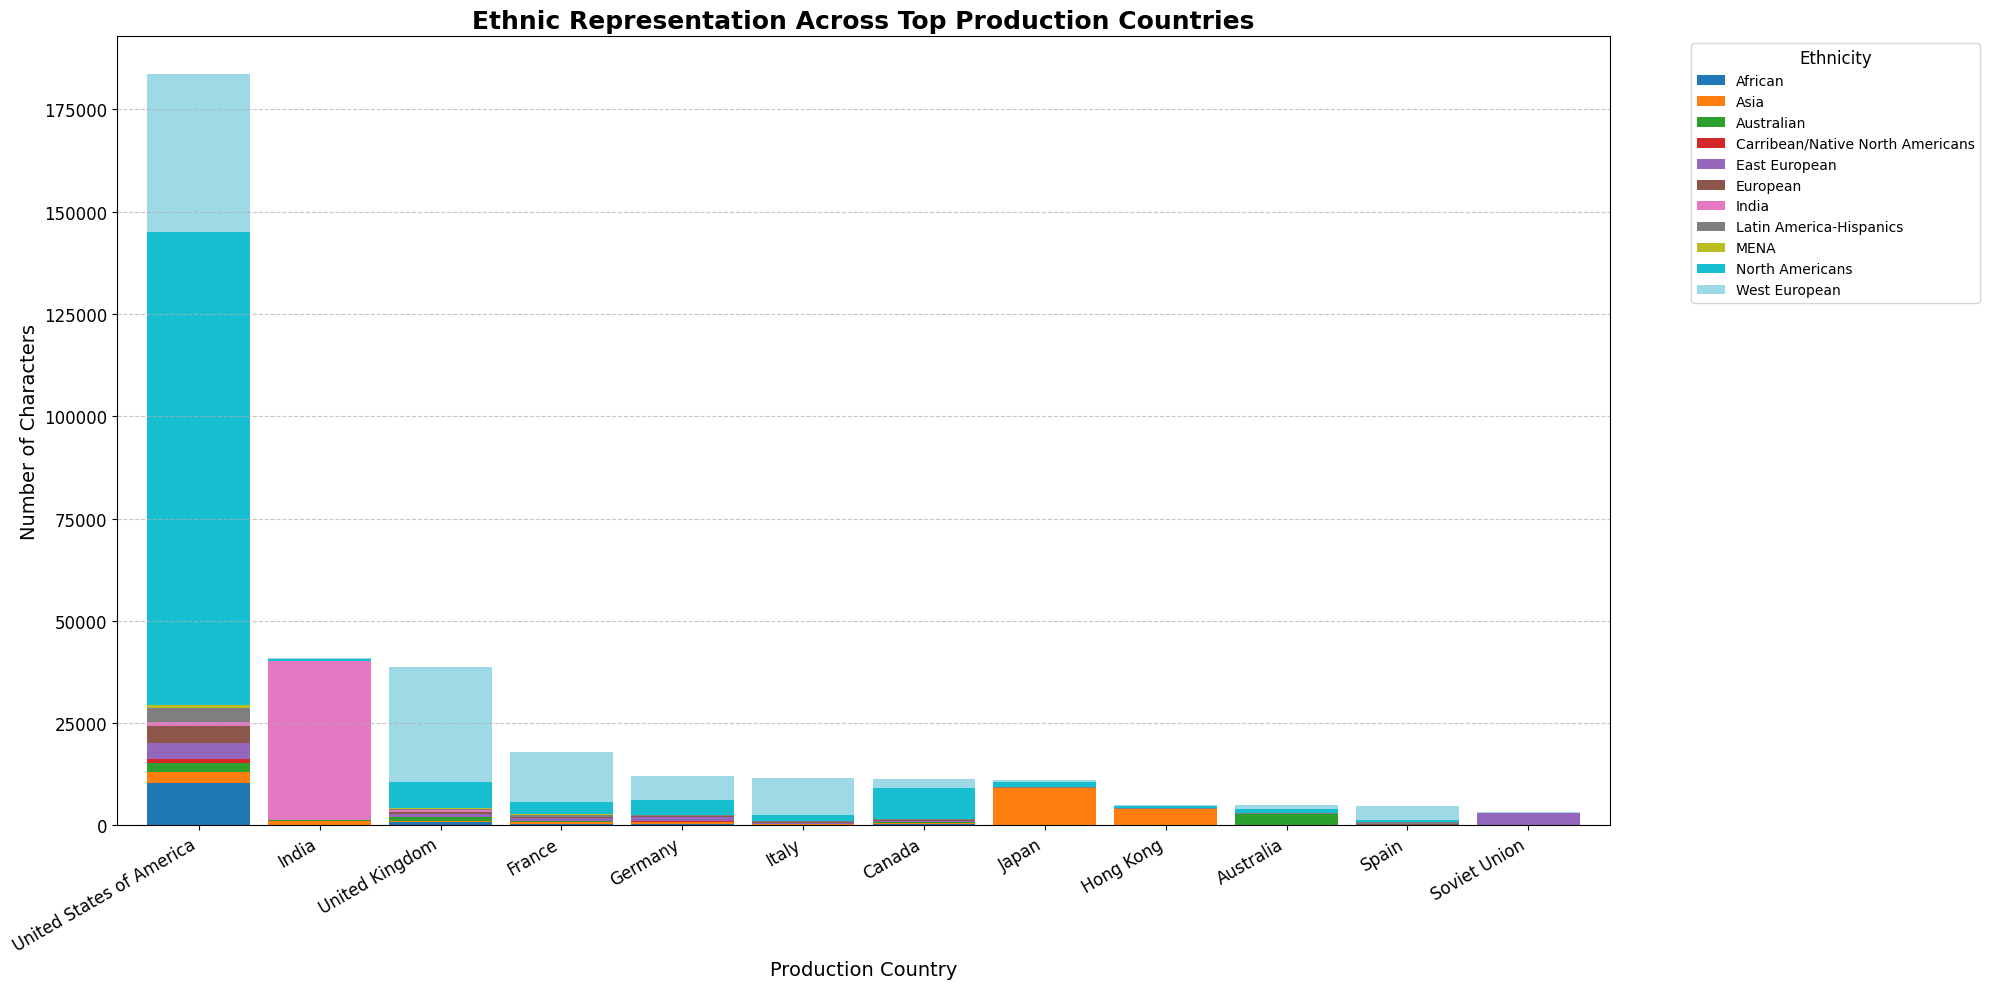

In [23]:
# Filter rows where both 'countries' and 'mapped_clusters' are not NaN
df_country_ethnicity = df_g_characters.dropna(subset=['countries', 'mapped_clusters'])
df_country_ethnicity_exploded = df_country_ethnicity.explode('countries').explode('mapped_clusters')

# Ethnicity representation by production country
country_ethnicity_trends = df_country_ethnicity_exploded.groupby(['countries', 'mapped_clusters']).size().unstack(fill_value=0)

# Select the top 20 countries by total representation for easier visualization
top_countries = country_ethnicity_trends.sum(axis=1).nlargest(12).index
country_ethnicity_top = country_ethnicity_trends.loc[top_countries]

plt.figure(figsize=(20, 10))  

# Plot the stacked bar chart
country_ethnicity_top.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Production Country", fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.title("Ethnic Representation Across Top Production Countries", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)  # Set rotation to 30 degrees

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()



Let's try percentages for better vizualization:

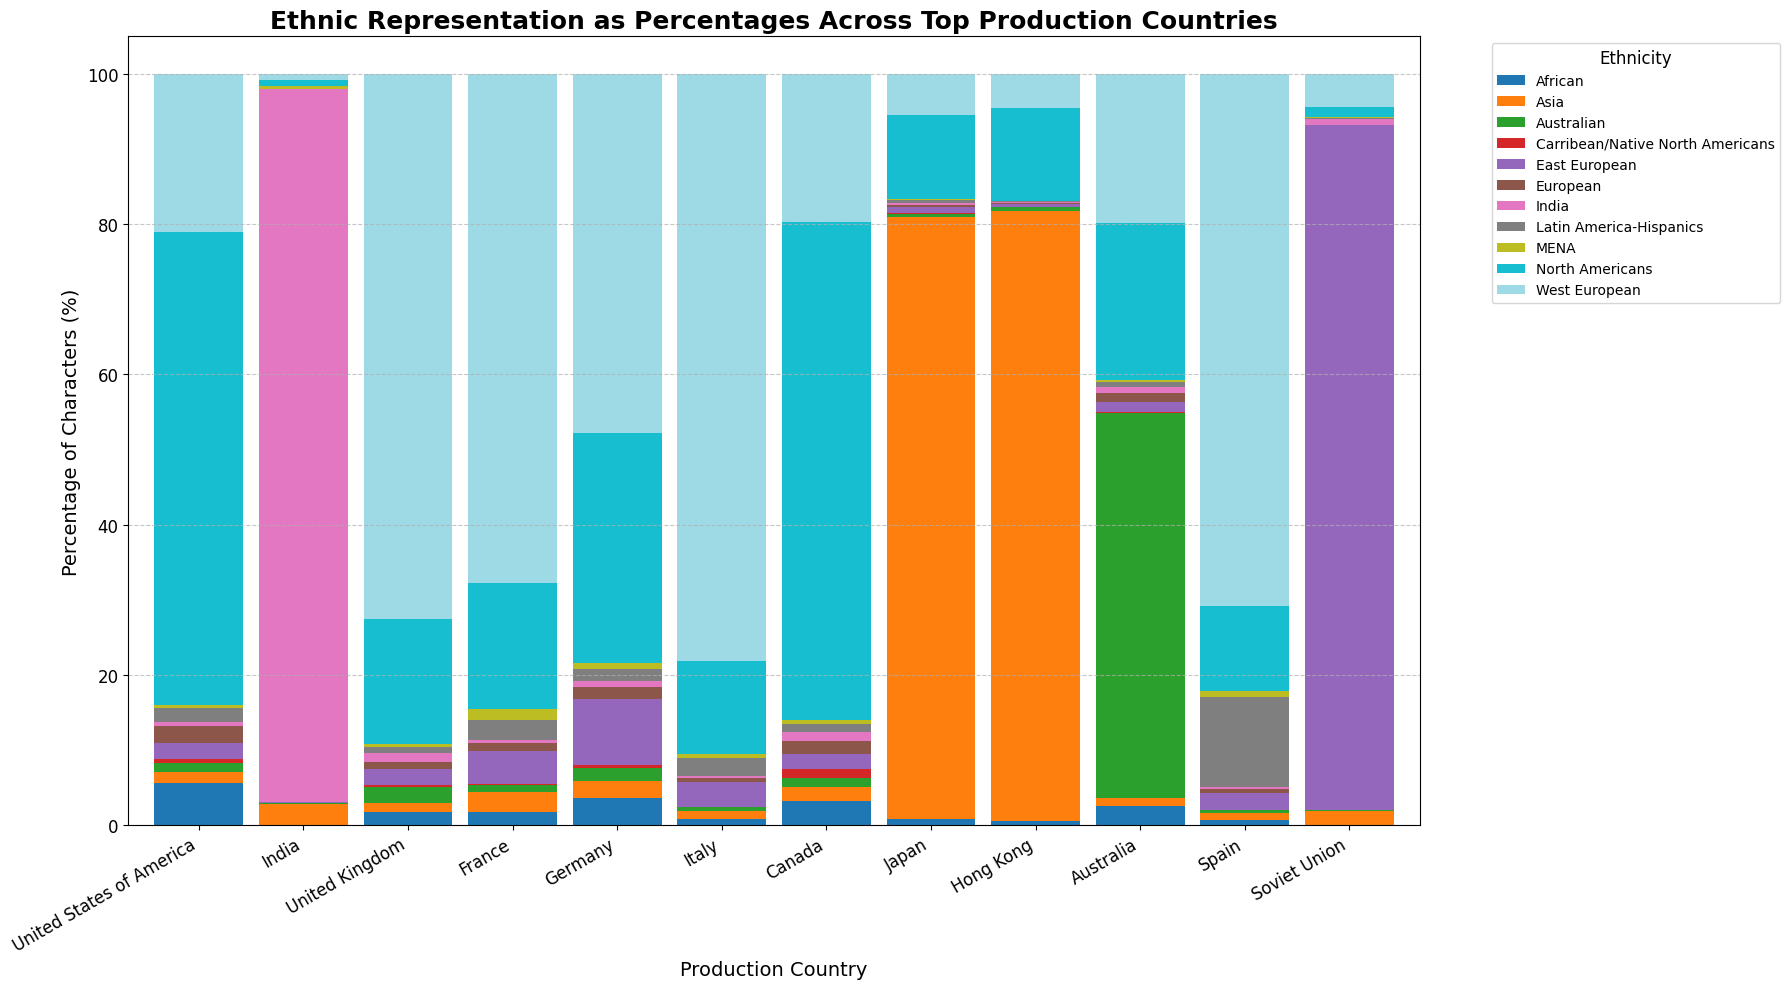

In [24]:
country_ethnicity_top_percent = country_ethnicity_top.div(country_ethnicity_top.sum(axis=1), axis=0) * 100

# Plot with updated size and legend adjustments
plt.figure(figsize=(18, 10))  # Larger figure size for readability

# Plot the stacked bar chart with percentage values
country_ethnicity_top_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Production Country", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Top Production Countries", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


In [25]:
continents = {
    'North America': ['United States of America', 'Canada', 'Mexico', 'Cuba', 'Puerto Rico',
                'Panama', 'Jamaica', 'Costa Rica', 'Bahamas', 'Haiti'],
    'Europe': ['United Kingdom', 'France', 'Italy', 'Germany','Spain', 'Netherland', 'Sweden', 
          'West Germany', 'Denmark', 'Czechoslovakia', 'Poland', 'Belgium', 'Norway', 'Hungary',
          'German Democratic Republic', 'Yugoslavia', 'Ireland', 'Switzerland', 'Asutria',
          'Czech Republic', 'Finland', 'England', 'Greece', 'Portugal', 'Croatia', 'Romania',
          'Bulgaria', 'Iceland', 'Luxembourg', 'Weimar Republic', 'Serbia', 'Scotland', 'Estonia',
          'Bosnia and Herzegovina', 'Slovakia', 'Slovenia', 'Albania', 'Ukraine', 'Nazi Germany',
          'Republic of Macedonia', 'Lithuania', 'Serbia and Montenegro','Socialist Federal Republic of Yugoslavia',
          'Kingdom of Great Britain', 'Federal Republic of Yugoslavia', 'Slovak Republic', 'Wales',
          'Monaco', 'Cyprus', 'Malta', 'Northern Ireland', 'Montenegro', 'Ukrainian SSR', 'Isle of Man',
          'Kingdom of Italy', 'Crime', 'German Language', 'Ukranian SSR'],
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Uruguay',
                 'Bolivia', 'Guinea', 'Aruba'],
    'Asia': ['India', 'Japan', 'Hong Kong', 'South Korea', 'China', 'Soviet Union', 'Philippines',
        'Russia', 'Israel', 'Turkey', 'Thailand', 'Taiwan', 'Iran', 'Pakistan', 'Indonesia',
        'Malaysia', 'Sri Lanka', 'Singapore', 'Bangladesh', 'Lebanon', 'Nepal', 'Vietnam',
        'Korea', 'Azerbaijan', 'Georgia', 'Iraq', 'United Arab Emirates', 'Afghanistan', 'Armenia',
        'Palestinian territories', 'Georgian SSR', 'Mandatory Palestine', 'Uzbek SSR', 'Uzbekistan',
        'Mongolia', 'Kuwait', 'Bahrain', 'Bhutan', 'Qatar', 'Soviet occupation zone', 'Malayalam Language',
        'Jordan', 'Iraqi Kurdistan', 'Republic of China', 'Macau', 'Palestinian Territories'],
    'Australia': ['Australia', 'New Zealand'],
    'Africa': ['South Africa', 'Egypt', 'Cambodia', 'Morocco', 'Senegal', 'Burkina Faso', 'Algeria', 
          'Tunisia', 'Burma', 'Nigeria', 'Republic Democratic of the Congo', 'Mali', 'Kenia',
          'Cameroon', 'Ethiopia', 'Zimbabwe', 'Congo', 'Libya', 'Zambia', 'Guinea-Bissau']
}

# dictionary to map each country to a continent
country_to_continent = {country: continent for continent, countries in continents.items() for country in countries}
# Drop rows with no country information
df_completeCountry = df_g_characters.dropna(subset=['countries'])

# Extract the first country name if 'countries' is a list (in case there are multiple countries per row)
df_completeCountry['countries'] = df_completeCountry['countries'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
)

# Map each country to its continent and create a new column 'continent'
df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)

# Display the DataFrame to verify
df_completeCountry.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_7002/927470218.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['countries'] = df_completeCountry['countries'].apply(
/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_7002/927470218.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completeCountry['continent'] = df_completeCountry['countries'].map(country_to_continent)


,wikipedia_id,character_name,actor_ethnicity,ethnicity_label,mapped_clusters,actor_name,countries,title,release_date,genres,continent
0,975900,Akooshay,NaN,United States of America,[North Americans],Wanda De Jesus,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America
1,975900,Lieutenant Melanie Ballard,/m/044038p,Canada,[North Americans],Natasha Henstridge,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America
2,975900,Desolation Williams,/m/0x67,African Americans,"[North Americans, African]",Ice Cube,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America
3,975900,Sgt Jericho Butler,NaN,United Kingdom,[West European],Jason Statham,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America
4,975900,Bashira Kincaid,NaN,United States of America,[North Americans],Clea DuVall,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America


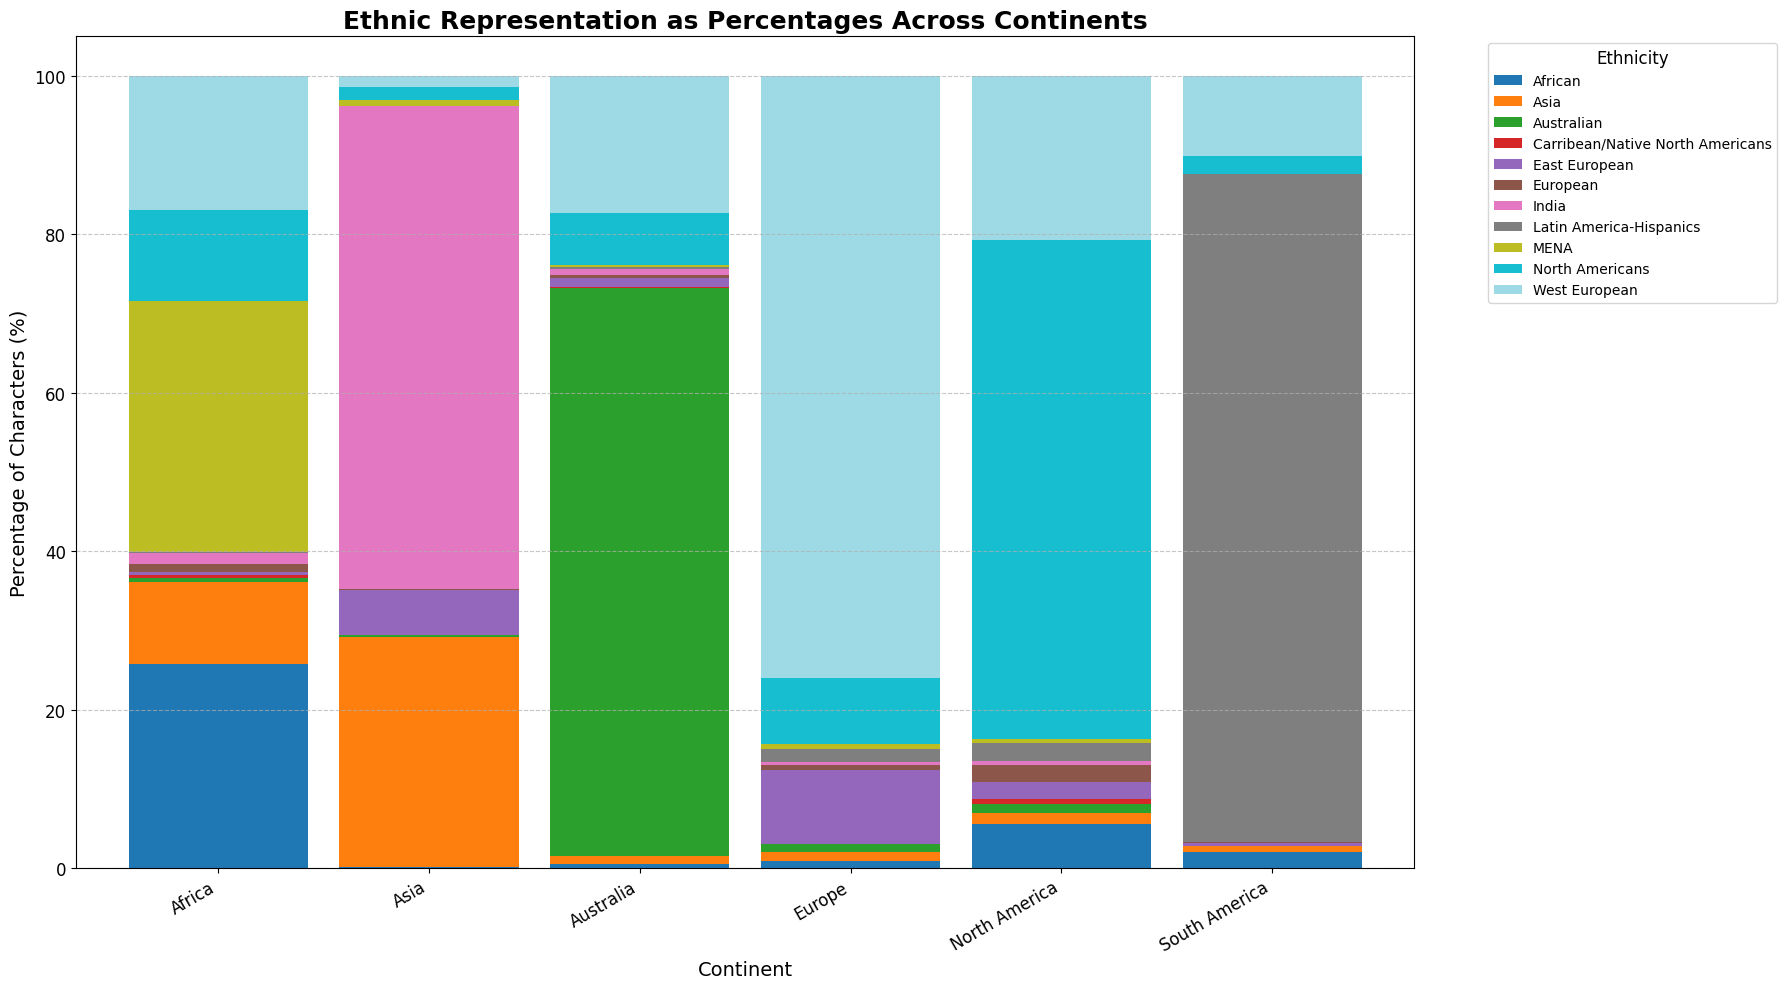

In [27]:
df_exploded = df_completeCountry.explode('mapped_clusters')

continent_ethnicity_trends = df_exploded.groupby(['continent', 'mapped_clusters']).size().unstack(fill_value=0)

continent_ethnicity_percent = continent_ethnicity_trends.div(continent_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(18, 10))  # Larger figure size for readability

# Plot the stacked bar chart with percentage values
continent_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Continent", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Continents", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()

The problem is that ethnicities are 

In [28]:
ethnicity_to_continent = {
    'African': ['Africa'],
    'Asia': ['Asia'],
    'West European': ['Europe'],
    'East European': ['Europe'],
    'European' : ['Europe'], 
    'MENA': ['Asia', 'Africa'],
    'Carribean/Native North Americans': ['North America'],
    'North Americans': ['North America'],
    'Australian': ['Australia'],
    'Latin America-Hispanics': ['South America'],
    'India': ['Asia'],
}


In [29]:
df_exploded['actor_continent'] = df_exploded['mapped_clusters'].map(ethnicity_to_continent)

# Display the DataFrame to verify the addition of the 'actor_continent' column
df_exploded.head()


,wikipedia_id,character_name,actor_ethnicity,ethnicity_label,mapped_clusters,actor_name,countries,title,release_date,genres,continent,actor_continent
0,975900,Akooshay,NaN,United States of America,North Americans,Wanda De Jesus,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America,[North America]
1,975900,Lieutenant Melanie Ballard,/m/044038p,Canada,North Americans,Natasha Henstridge,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America,[North America]
2,975900,Desolation Williams,/m/0x67,African Americans,North Americans,Ice Cube,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America,[North America]
2,975900,Desolation Williams,/m/0x67,African Americans,African,Ice Cube,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America,[Africa]
3,975900,Sgt Jericho Butler,NaN,United Kingdom,West European,Jason Statham,United States of America,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",North America,[Europe]


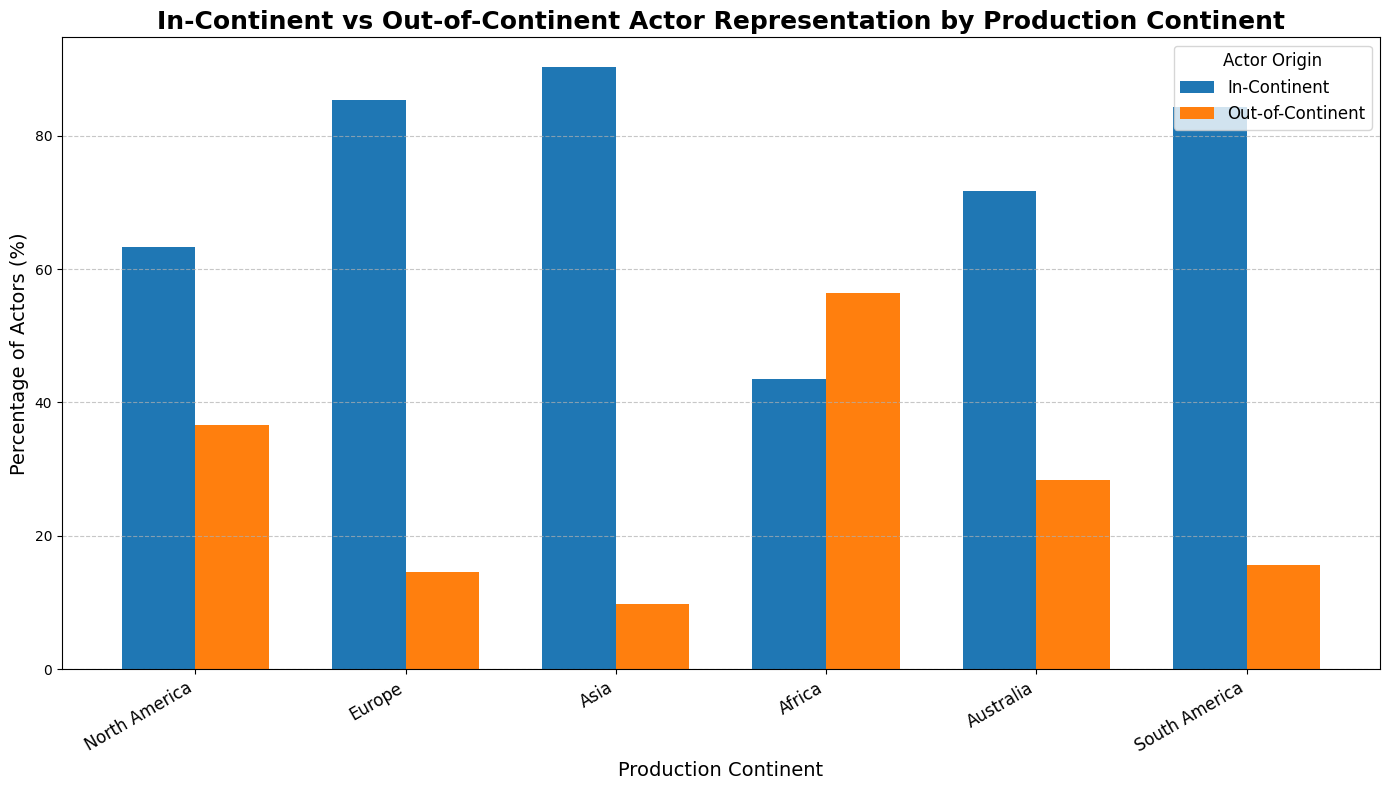

In [32]:
df_exploded = df_exploded.explode('actor_continent')
# Remove rows with NaNs in 'continent' or 'actor_continent' for accurate calculations
df_exploded_filtered = df_exploded.dropna(subset=['continent', 'actor_continent'])

# Dictionary to store in-continent and out-of-continent percentages
continent_actor_percentage = {}

# Loop through each unique production continent
for production_continent in df_exploded_filtered['continent'].unique():
    # Filter data where the movie production is in the current continent
    df_current_production_continent = df_exploded_filtered[df_exploded_filtered['continent'] == production_continent]
    
    # Calculate the number of actors from the same continent as the production continent (in-continent)
    in_continent_count = df_current_production_continent[df_current_production_continent['actor_continent'] == production_continent].shape[0]
    
    # Calculate total number of actors for this production continent
    total_actors = df_current_production_continent.shape[0]
    
    # Calculate in-continent and out-of-continent percentages
    in_continent_percentage = (in_continent_count / total_actors) * 100 if total_actors > 0 else 0
    out_continent_percentage = 100 - in_continent_percentage
    
    # Store in and out percentages for this continent in the dictionary
    continent_actor_percentage[production_continent] = {
        'In-Continent': in_continent_percentage,
        'Out-of-Continent': out_continent_percentage
    }

# Extract lists for plotting
continents = list(continent_actor_percentage.keys())
in_continent_percentages = [percentages['In-Continent'] for percentages in continent_actor_percentage.values()]
out_continent_percentages = [percentages['Out-of-Continent'] for percentages in continent_actor_percentage.values()]

# Define bar width and positions
bar_width = 0.35
x = np.arange(len(continents))

# Create figure
plt.figure(figsize=(14, 8))

# Plot in-continent and out-of-continent bars
plt.bar(x - bar_width/2, in_continent_percentages, width=bar_width, label='In-Continent', color='#1f77b4')
plt.bar(x + bar_width/2, out_continent_percentages, width=bar_width, label='Out-of-Continent', color='#ff7f0e')

# Add labels and title
plt.xlabel("Production Continent", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("In-Continent vs Out-of-Continent Actor Representation by Production Continent", fontsize=18, fontweight='bold')

# Set x-ticks to be the continent names
plt.xticks(ticks=x, labels=continents, rotation=30, ha="right", fontsize=12)

# Add legend
plt.legend(title="Actor Origin", fontsize=12, title_fontsize=12, loc='upper right')

# Optional grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()
plt.show()




North America seems to have the most diversity in it's cast compared to other continents. South America seems to be the one that has casts most reflective of it. 

## Closer look into each continent: 

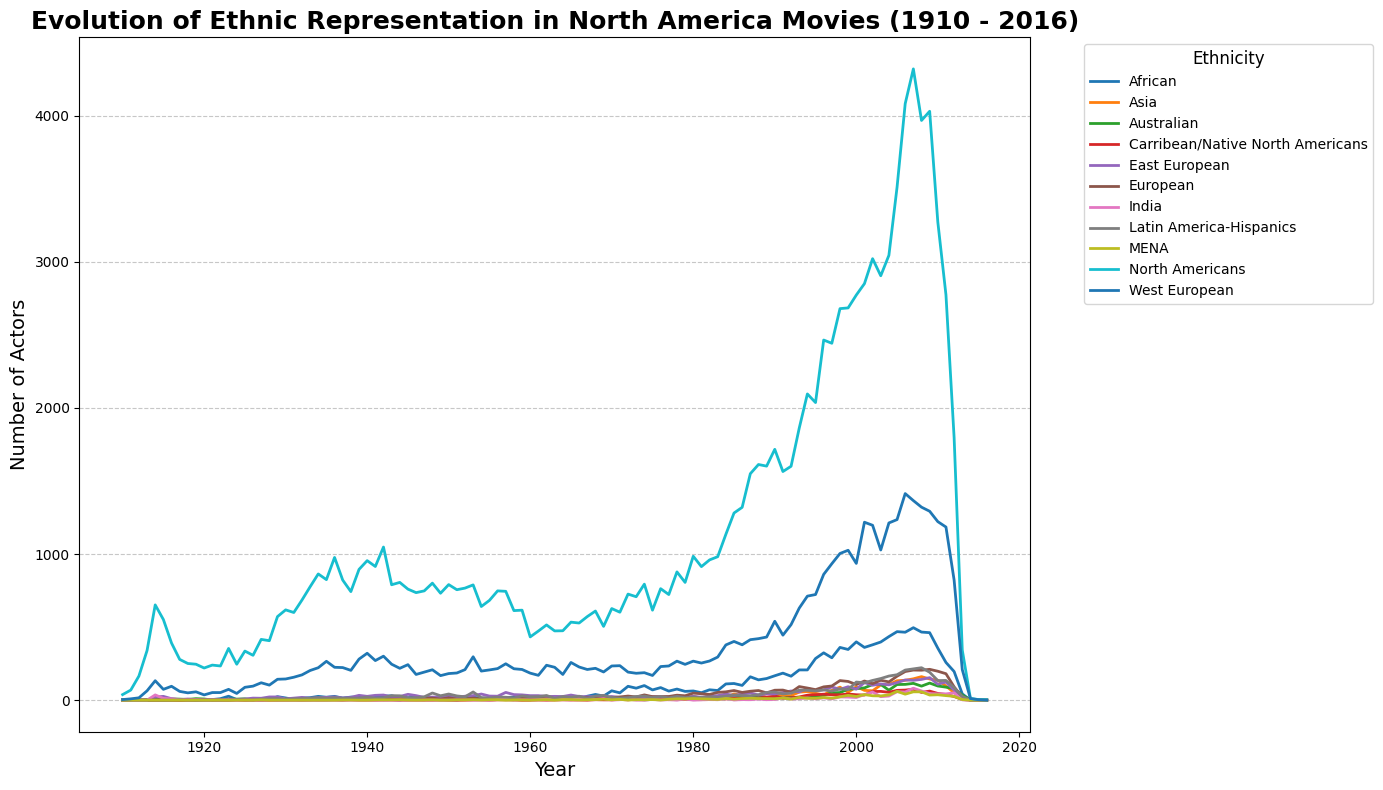

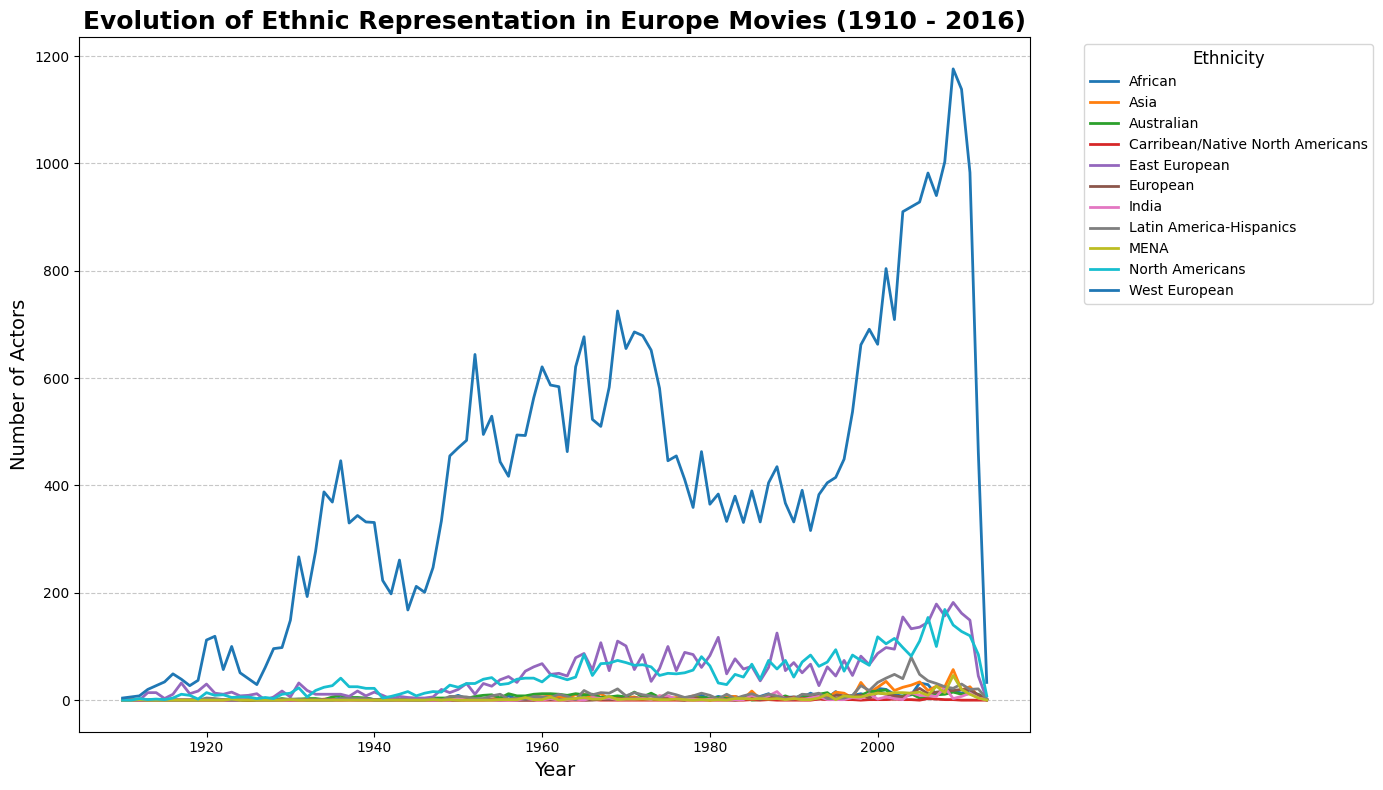

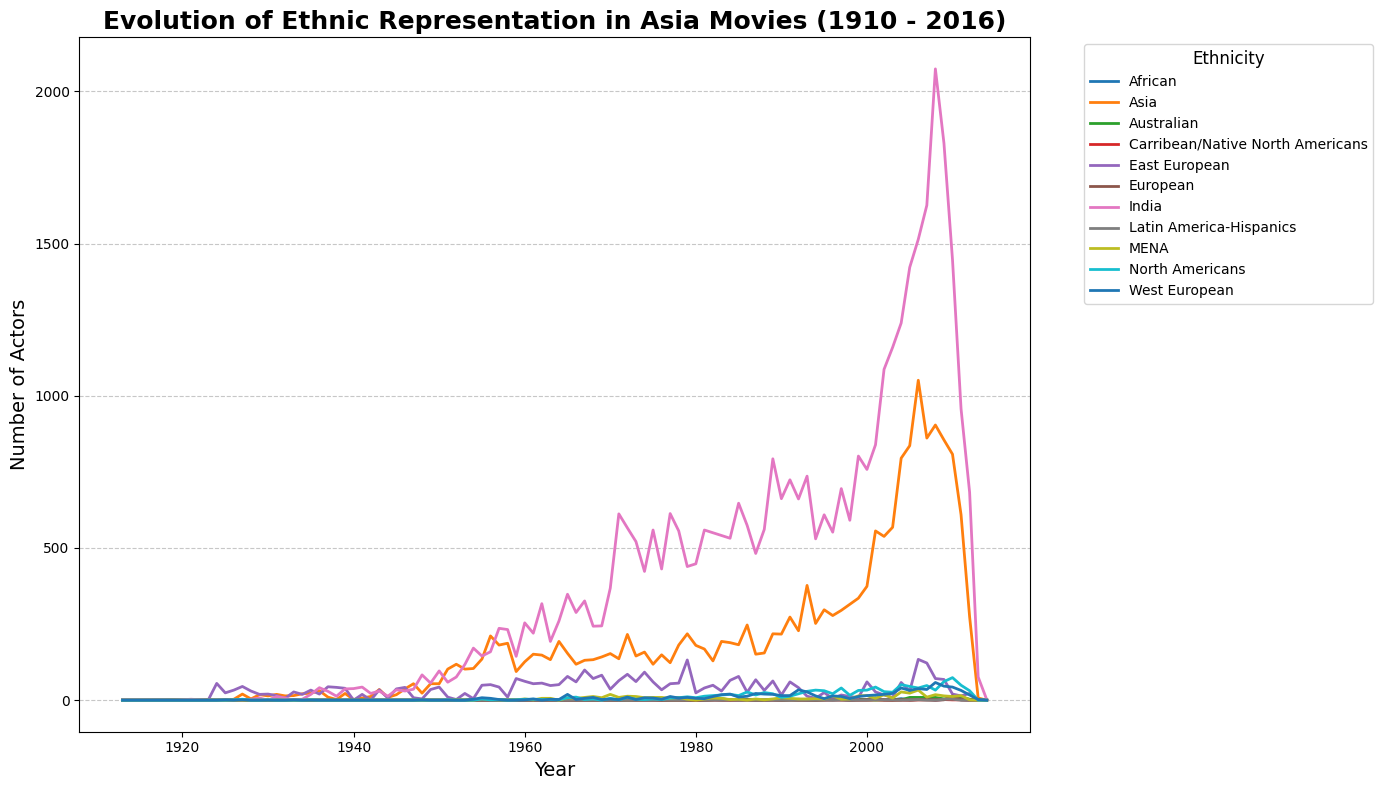

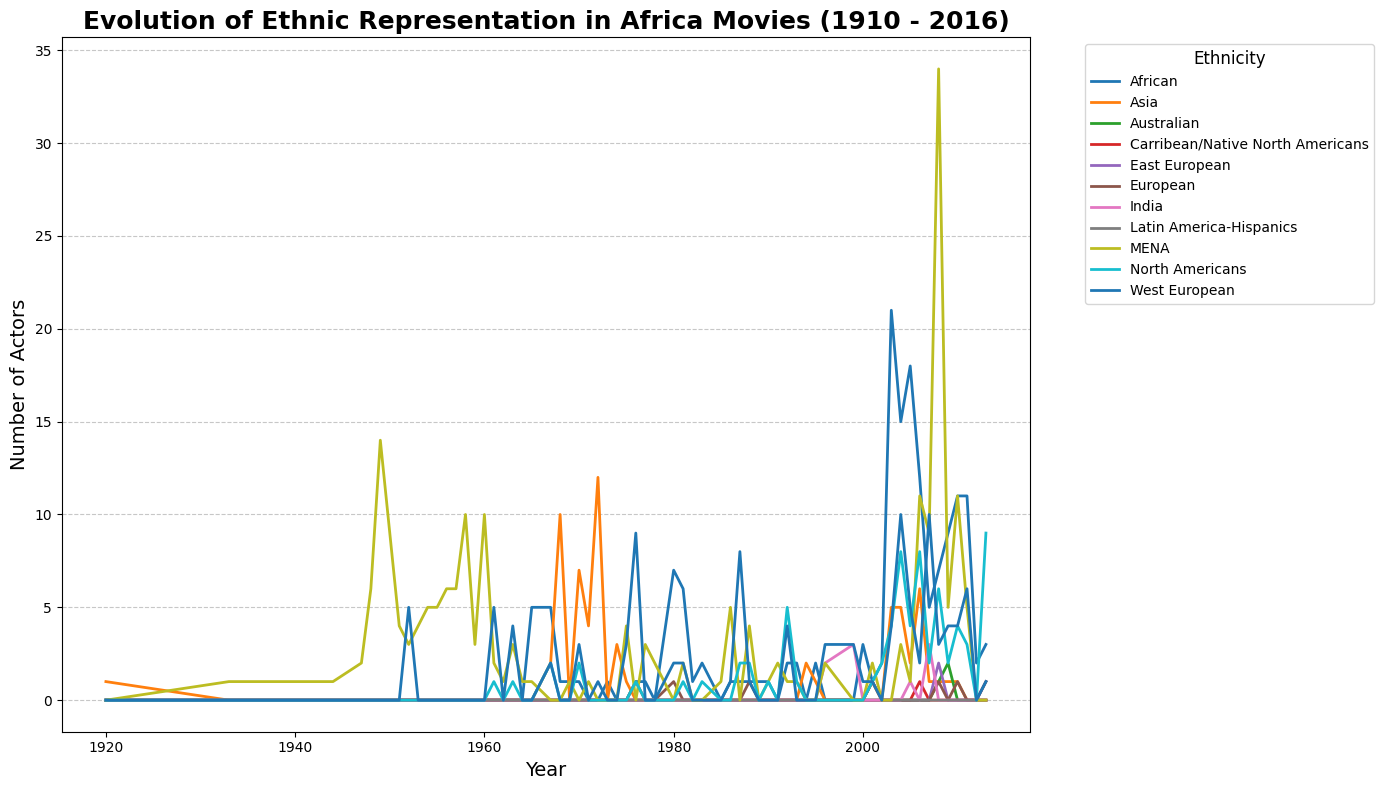

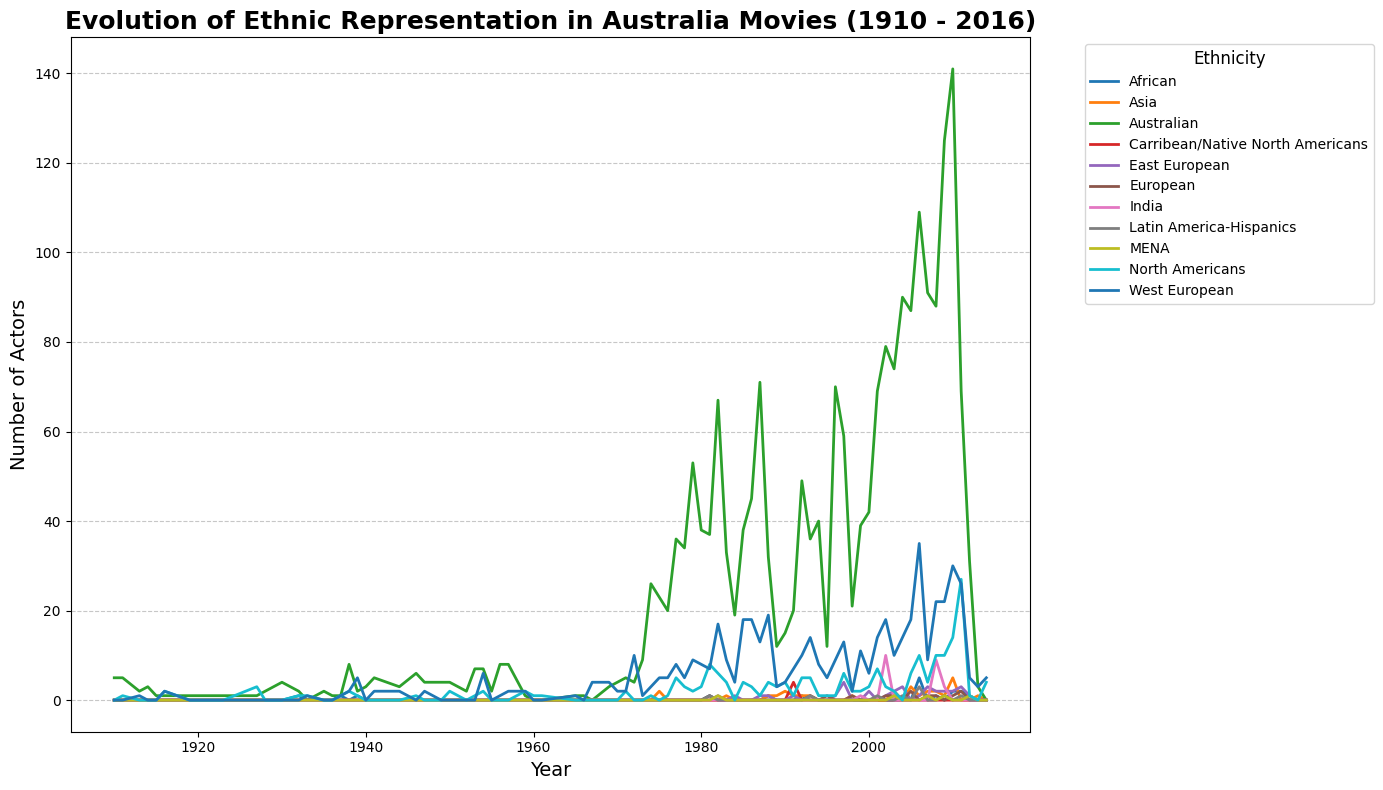

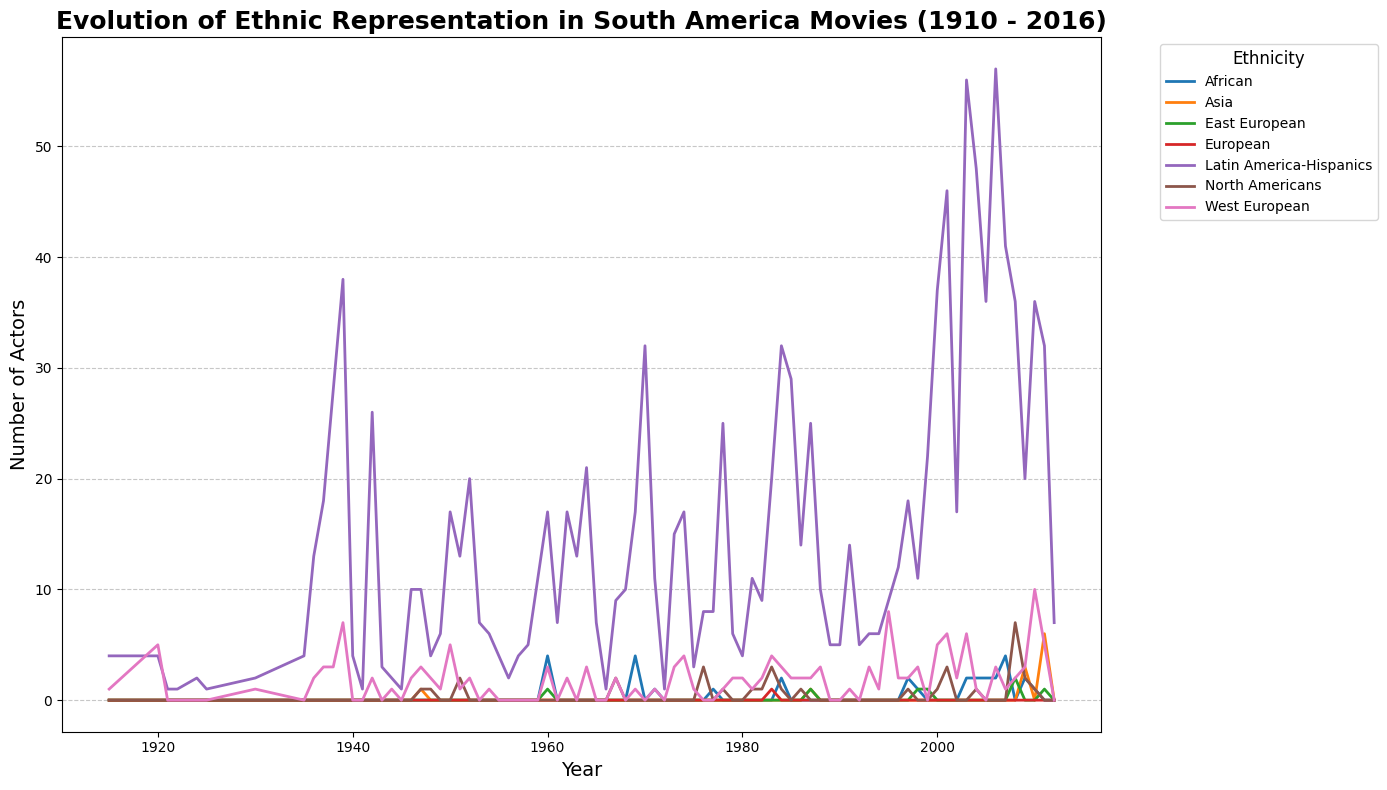

In [33]:
# Filter data for years between 1910 and 2016
df_filtered_years = df_completeCountry[(df_completeCountry['release_date'] >= 1910) & (df_completeCountry['release_date'] <= 2016)]

# Loop through each continent in the 'continent' column
for continent in df_filtered_years['continent'].dropna().unique():
    # Filter data for the current continent
    df_current_continent = df_filtered_years[df_filtered_years['continent'] == continent]
    
    # Explode 'mapped_clusters' column to handle multiple ethnicities per actor
    df_exploded = df_current_continent.explode('mapped_clusters')
    
    # Group by year and ethnicity, counting occurrences
    ethnicity_counts_by_year = (
        df_exploded.groupby(['release_date', 'mapped_clusters'])
        .size()
        .unstack(fill_value=0)
    )
    
    # Plot the evolution for each ethnicity over time within the current continent
    plt.figure(figsize=(14, 8))
    for ethnicity in ethnicity_counts_by_year.columns:
        plt.plot(
            ethnicity_counts_by_year.index,
            ethnicity_counts_by_year[ethnicity],
            label=ethnicity,
            linewidth=2
        )
    
    # Labeling and layout improvements
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Number of Actors", fontsize=14)
    plt.title(f"Evolution of Ethnic Representation in {continent} Movies (1910 - 2016)", fontsize=18, fontweight='bold')
    plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



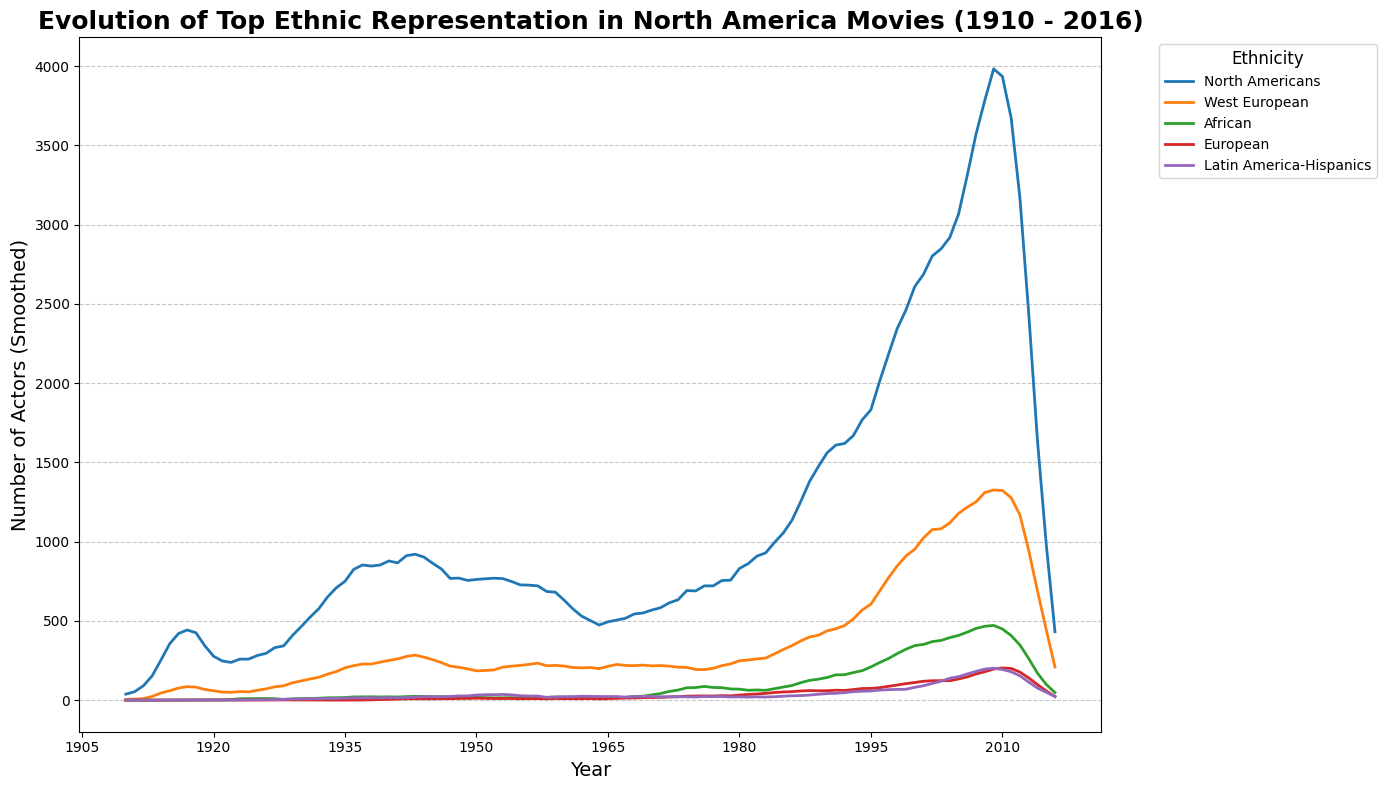

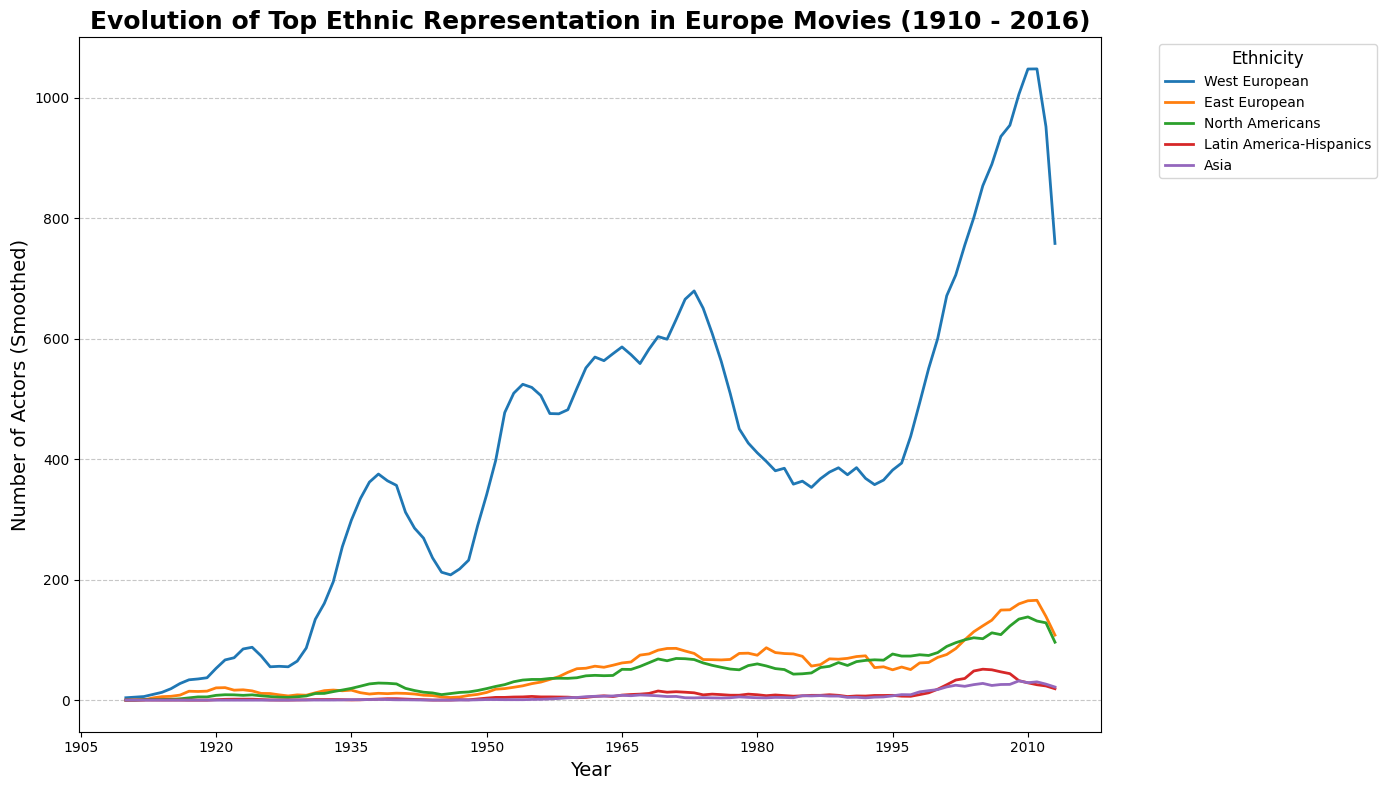

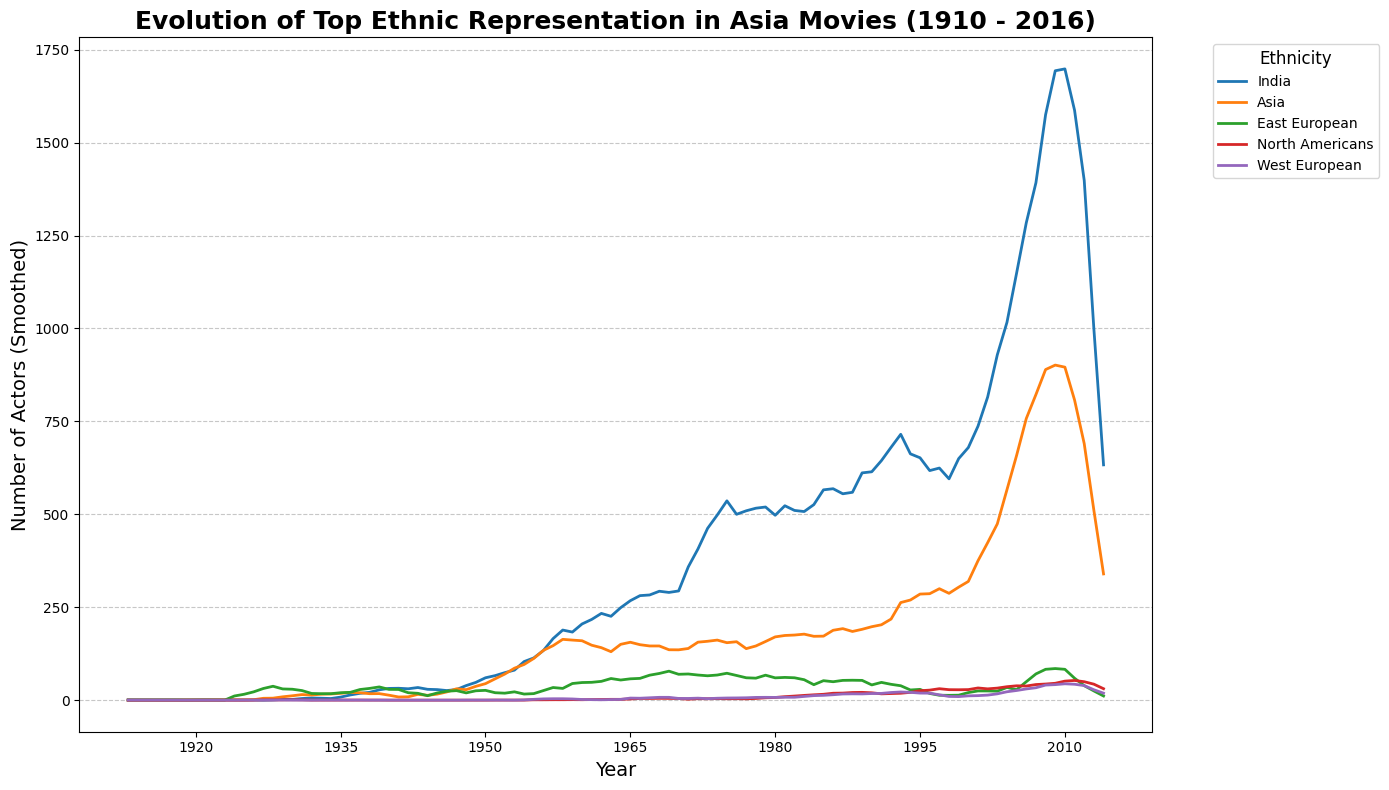

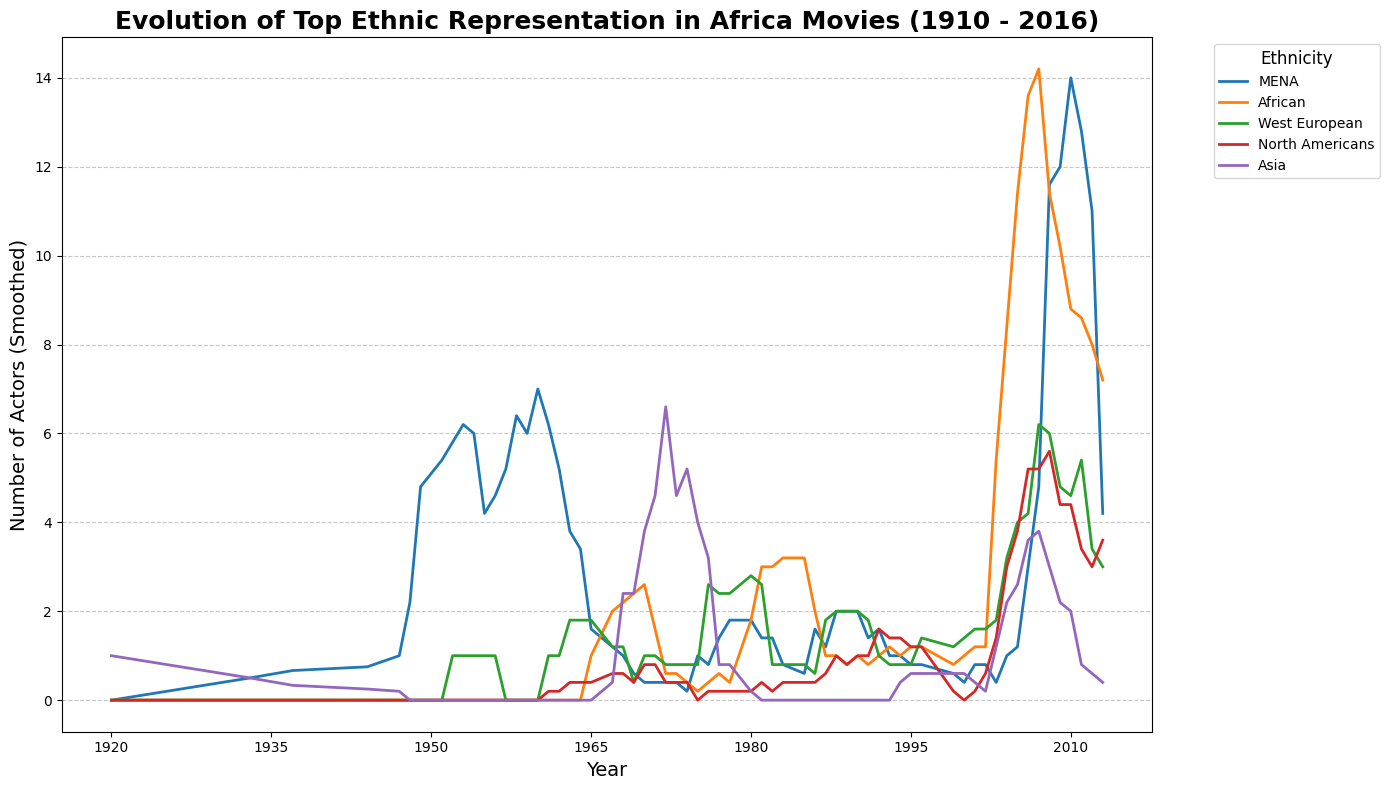

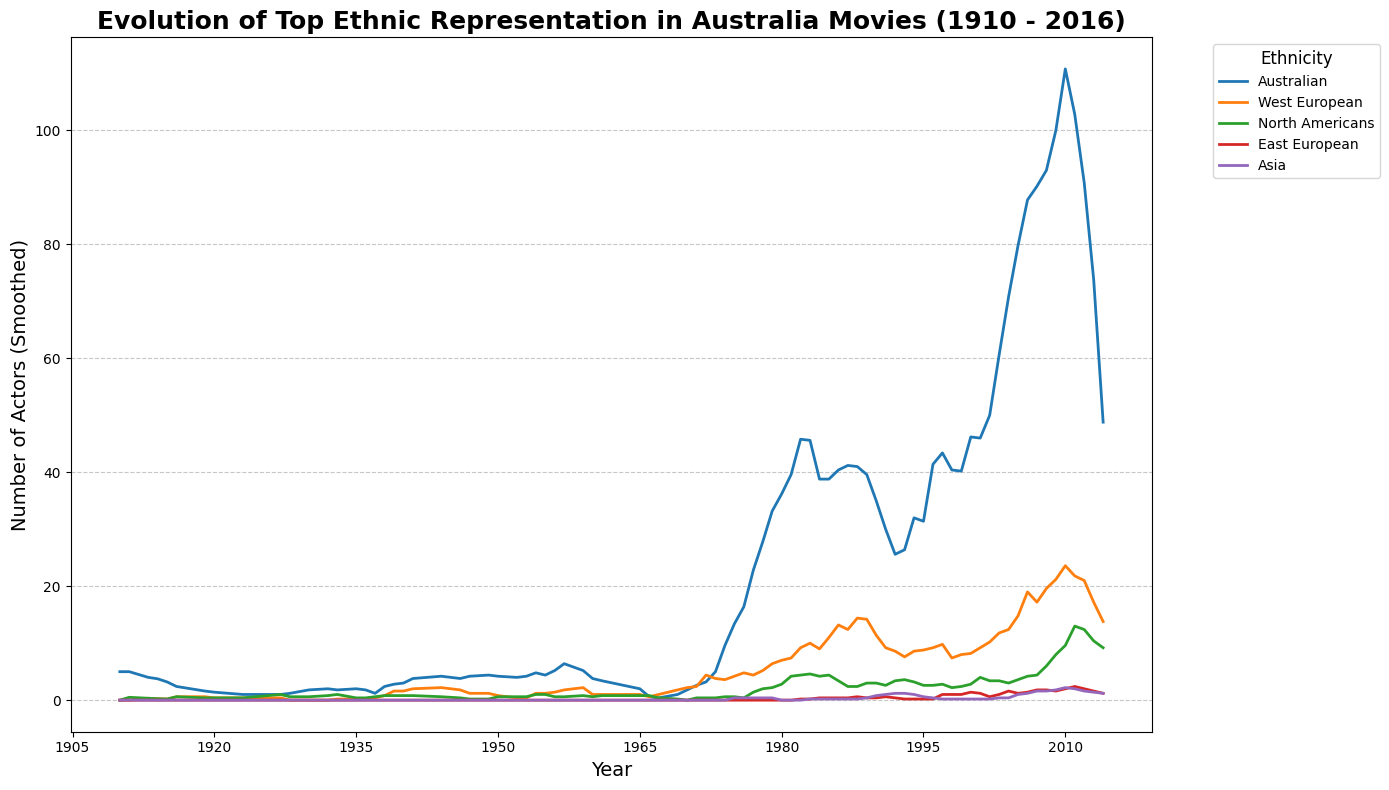

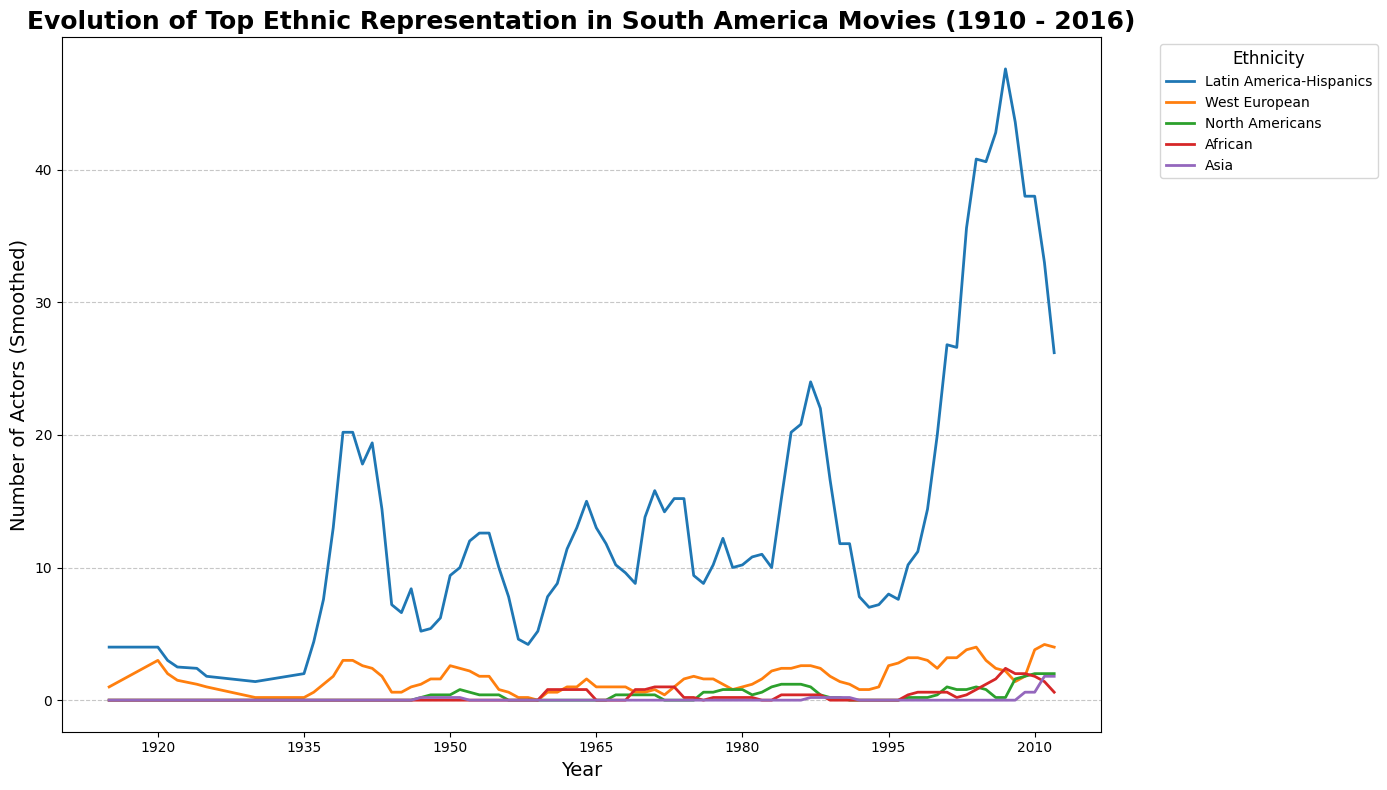

In [35]:
from matplotlib.ticker import MaxNLocator
# Loop through each continent in the 'continent' column
for continent in df_filtered_years['continent'].dropna().unique():
    # Filter data for the current continent
    df_current_continent = df_filtered_years[df_filtered_years['continent'] == continent]
    
    # Explode 'mapped_clusters' column to handle multiple ethnicities per actor
    df_exploded = df_current_continent.explode('mapped_clusters')
    
    # Group by year and ethnicity, counting occurrences
    ethnicity_counts_by_year = (
        df_exploded.groupby(['release_date', 'mapped_clusters'])
        .size()
        .unstack(fill_value=0)
    )
    
    # Optionally, filter to top ethnicities by total count over the period
    top_ethnicities = ethnicity_counts_by_year.sum().nlargest(5).index
    ethnicity_counts_by_year = ethnicity_counts_by_year[top_ethnicities]
    
    # Apply a rolling mean for smoother trends (window=5 years)
    ethnicity_counts_smoothed = ethnicity_counts_by_year.rolling(window=5, min_periods=1).mean()
    
    # Plot the evolution for each ethnicity over time within the current continent
    plt.figure(figsize=(14, 8))
    for ethnicity in ethnicity_counts_smoothed.columns:
        plt.plot(
            ethnicity_counts_smoothed.index,
            ethnicity_counts_smoothed[ethnicity],
            label=ethnicity,
            linewidth=2
        )
    
    # Labeling and layout improvements
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Number of Actors (Smoothed)", fontsize=14)
    plt.title(f"Evolution of Top Ethnic Representation in {continent} Movies (1910 - 2016)", fontsize=18, fontweight='bold')
    plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Use MaxNLocator to control x-axis tick frequency
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    
    plt.tight_layout()
    plt.show()


1. **Australia**: Dominantly represented by Australians, with noticeable growth in the 1980s and peaking in the early 2000s. Other ethnicities like West European and North Americans remain consistently low.

2. **South America**: Latin America-Hispanic representation is highest, showing moderate growth, especially around the 1940s and the late 1990s. Other ethnicities have minimal presence.

3. **North America**: North Americans are the most represented, with a sharp increase starting in the 1960s, peaking around 2000. West Europeans and African ethnicities follow with lower but steady growth over time.

4. **Europe**: West Europeans dominate the representation, especially after 1930, with a significant rise around the 1950s. East Europeans and North Americans have minimal but visible representation.

5. **Asia**: Indian and Asian ethnicities dominate, showing steady growth, particularly after the 1960s. Other ethnic groups have minor representation throughout the years.

### How about in the different genres? 

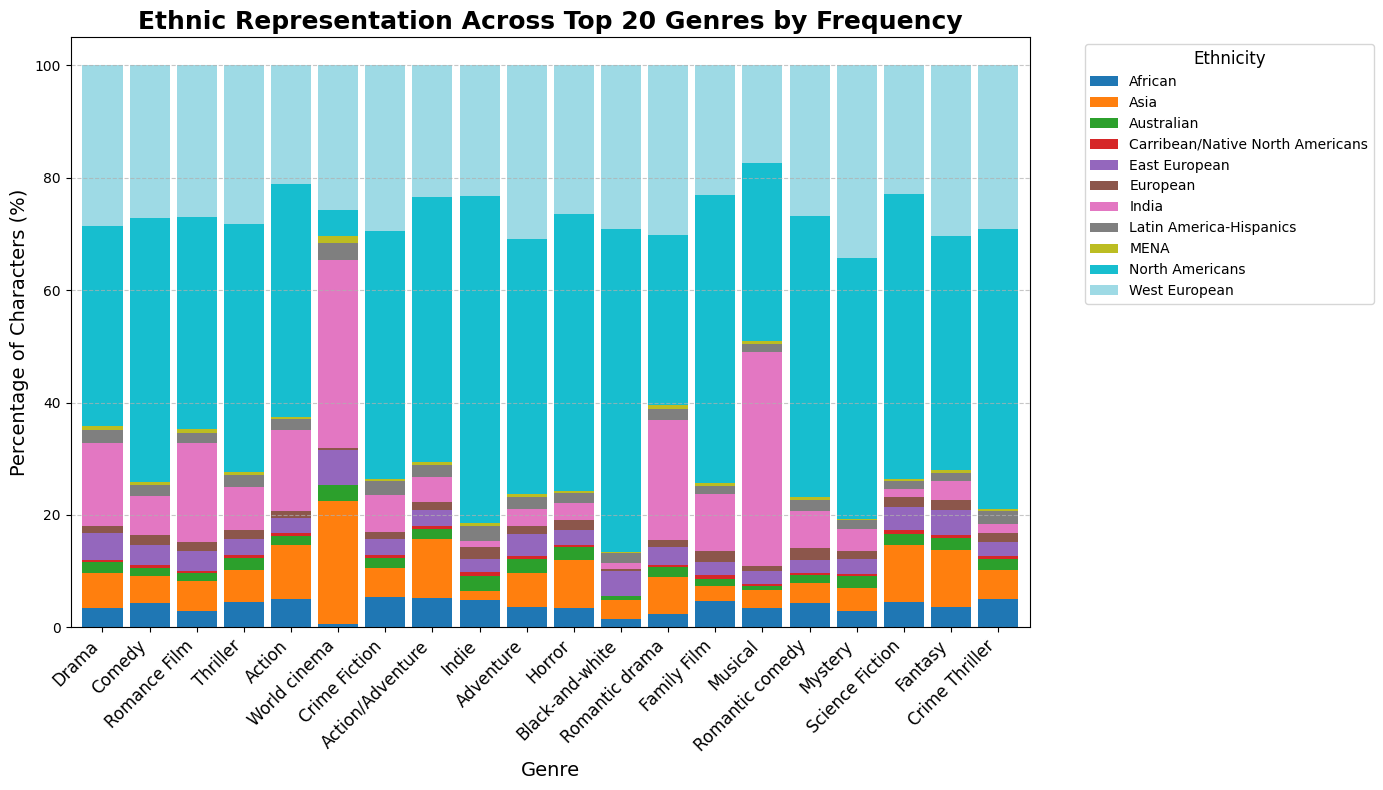

In [37]:
df_completeCountry_exploded = df_completeCountry.explode('genres').explode('mapped_clusters')

# Group by genre and ethnicity to get the count of characters per ethnicity in each genre
genre_ethnicity_counts = df_completeCountry_exploded.groupby(['genres', 'mapped_clusters']).size().unstack(fill_value=0)

# Select the top 20 genres by frequency (total number of entries in each genre)
top_genres = df_completeCountry_exploded['genres'].value_counts().nlargest(20).index

# Filter genre-ethnicity counts for the top 20 genres
genre_ethnicity_top = genre_ethnicity_counts.loc[top_genres]

# Normalize counts to percentages within each genre
genre_ethnicity_percentages = genre_ethnicity_top.div(genre_ethnicity_top.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart for ethnic representation across the top 20 genres
plt.figure(figsize=(14, 8))
genre_ethnicity_percentages.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Percentage of Characters (%)", fontsize=14)
plt.title("Ethnic Representation Across Top 20 Genres by Frequency", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=45, ha="right", fontsize=12)

# Add legend outside the plot
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()




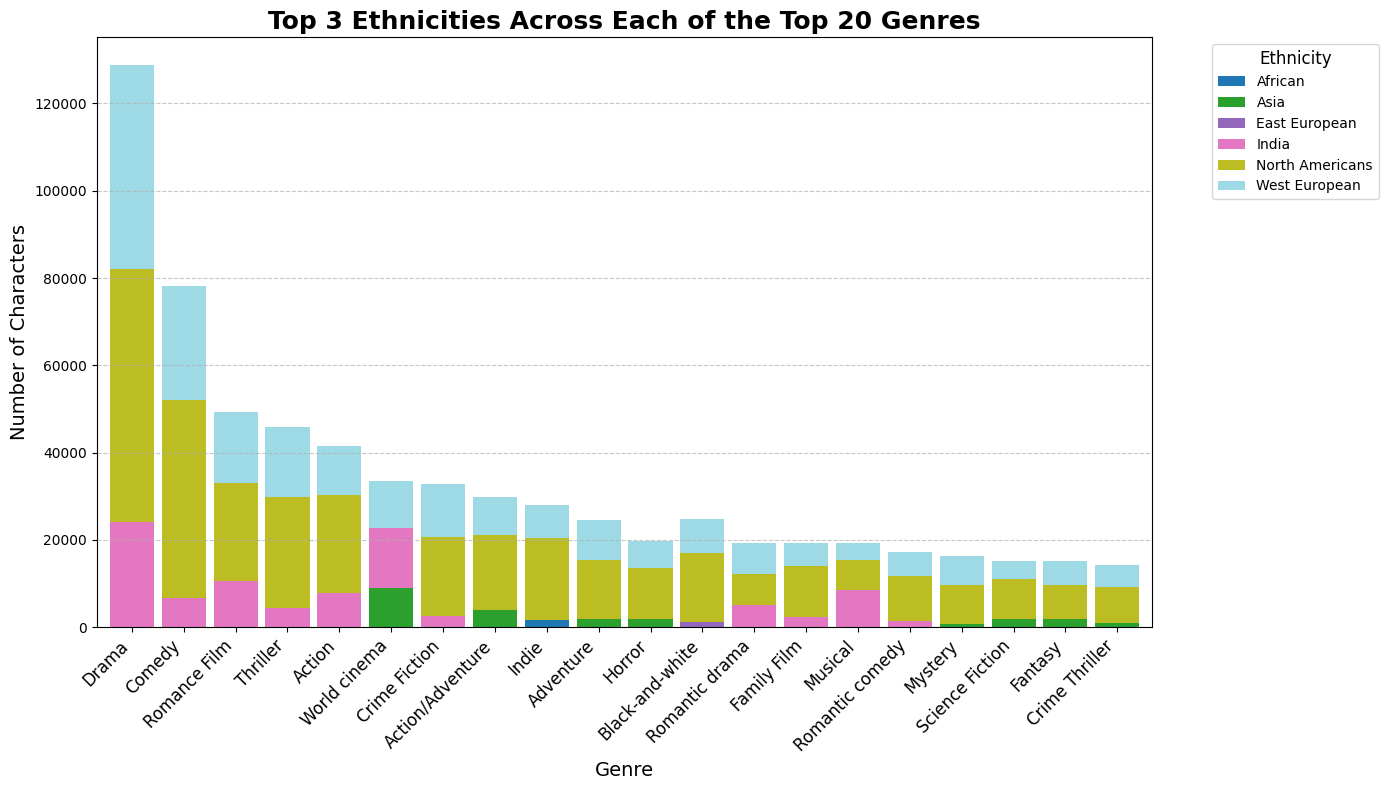

In [38]:
top_3_ethnicities_per_genre = genre_ethnicity_top.apply(lambda x: x.nlargest(3), axis=1).fillna(0)

# Plot the top 3 ethnicities for each genre in the top 20 genres
plt.figure(figsize=(14, 8))
top_3_ethnicities_per_genre.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements for top 3 ethnicities
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.title("Top 3 Ethnicities Across Each of the Top 20 Genres", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Looking at the nb of ethnicities in each movies: 
needs to be redone based on the right classification of ethnicities ( europe being west and east and stil having europe as a group itself can be falsifying the results for the primary simple diversity score)
+ need to look at other diversity score idease

In [42]:
movie_ethnicity_stats = df_g_characters.groupby('wikipedia_id').agg(
    num_characters=('character_name', 'size'),  # Total characters per movie
    num_ethnicities=('mapped_clusters', lambda x: len(set([ethnicity for clusters in x if clusters for ethnicity in clusters]))),  # Count unique ethnicities
    num_ethnicities_available=('mapped_clusters', lambda x: sum(1 for clusters in x if clusters)),  # Count non-empty ethnicity entries
    num_characters_with_ethnicity=('mapped_clusters', lambda x: sum(1 for clusters in x if clusters))  # Count characters with any ethnicity data
).reset_index()

# Display the head of the resulting DataFrame
movie_ethnicity_stats.head(20)

,wikipedia_id,num_characters,num_ethnicities,num_ethnicities_available,num_characters_with_ethnicity
0,330,4,1,1,1
1,3217,14,3,10,10
2,3333,15,2,13,13
3,3746,15,4,9,9
4,3837,20,5,13,13
5,3947,15,3,7,7
6,4227,10,3,8,8
7,4231,17,2,11,11
8,4560,16,3,12,12
9,4726,11,4,7,7


In [40]:
movie_ethnicity_stats['num_ethnicities'].describe()

count    60623.000000
mean         1.661531
std          1.125068
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: num_ethnicities, dtype: float64

The mean, median, and 75th percentile being close to 1-2 unique ethnicities suggest that many movies in the dataset are relatively homogeneous in terms of ethnic representation.

In [43]:
# Calculate the diversity score based on characters with available ethnicity data
movie_ethnicity_stats['diversity_score'] = movie_ethnicity_stats['num_ethnicities'] / movie_ethnicity_stats['num_characters_with_ethnicity']

# Replace infinite values (if any) with NaN
movie_ethnicity_stats['diversity_score'] = movie_ethnicity_stats['diversity_score'].replace([float('inf')], np.nan)

# Display the updated DataFrame
movie_ethnicity_stats.head()


,wikipedia_id,num_characters,num_ethnicities,num_ethnicities_available,num_characters_with_ethnicity,diversity_score
0,330,4,1,1,1,1.000000
1,3217,14,3,10,10,0.300000
2,3333,15,2,13,13,0.153846
3,3746,15,4,9,9,0.444444
4,3837,20,5,13,13,0.384615


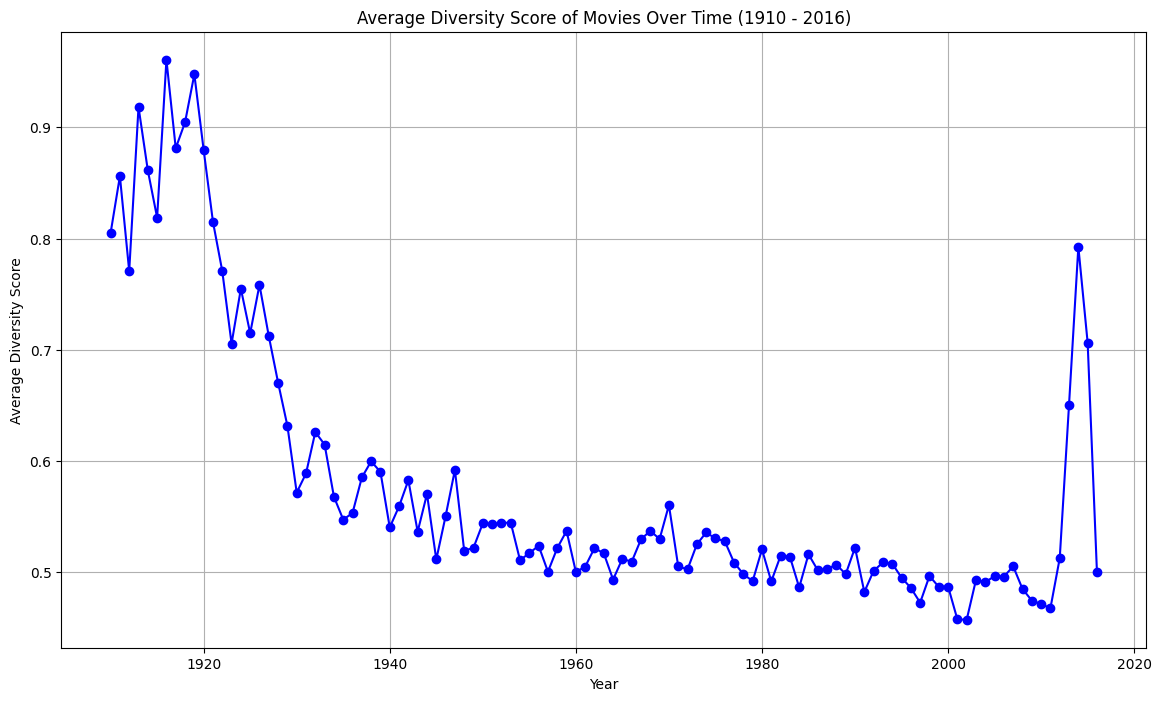

In [51]:
movie_ethnicity_stats_with_year = movie_ethnicity_stats.merge(df_g_characters[['wikipedia_id', 'release_date']], on='wikipedia_id', how='left').drop_duplicates('wikipedia_id')

# Filter for the year range between 1910 and 2013
movie_ethnicity_stats_with_year = movie_ethnicity_stats_with_year[
    (movie_ethnicity_stats_with_year['release_date'] >= 1910) &
    (movie_ethnicity_stats_with_year['release_date'] <= 2016)
]

# Group by year and calculate the average diversity score
diversity_over_time = movie_ethnicity_stats_with_year.groupby('release_date')['diversity_score'].mean()

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(diversity_over_time.index, diversity_over_time.values, marker='o', color='b')
plt.title("Average Diversity Score of Movies Over Time (1910 - 2016)")
plt.xlabel("Year")
plt.ylabel("Average Diversity Score")
plt.grid(True)
plt.show()

